In [2]:
import pandas as pd
import numpy as np

from mpl_toolkits.axes_grid1.inset_locator import inset_axes # inset
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

# qqplot
import statsmodels.api as sm
import pylab as py

from scipy.stats import mannwhitneyu,wilcoxon,spearmanr,ttest_ind
from scipy.stats import sem

In [3]:
%load_ext rpy2.ipython

from rpy2.robjects.packages import importr
# import R's "base" package
lme4 = importr('lme4')
mass = importr('MASS')
rcompanion = importr('rcompanion')

In [4]:
# Set the style to remove top and right borders
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
# set the font
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 12})
# remove legend edge
plt.rcParams['legend.frameon'] = False

In [5]:
def as_si(x, ndp):
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    return r'{m:s}\times 10^{{{e:d}}}'.format(m=m, e=int(e))

# add p-value to figure
def text(p):
    if (0.001 < p < 0.01)|(p == 0.001):
        axs.text((x1+x2)*.5, y+h,  r"**", ha='center', va='bottom', color=col, fontsize = 8)
    elif p < 0.001:
        axs.text((x1+x2)*.5, y+h, r"***", ha='center', va='bottom', color=col, fontsize = 8)
    elif (0.01 < p < 0.05)|(p == 0.01):
        axs.text((x1+x2)*.5, y+h, r"*", ha='center', va='bottom', color=col, fontsize = 8)
    else:
        axs.text((x1+x2)*.5, y+h, r"n.s.", ha='center', va='bottom', color=col, fontsize = 8)

# Load data

In [6]:
home_dir = '/Users/dbao/My_Drive'+'/road_construction/data/2022_online/'
data_dir = home_dir + 'R_analysis_data/'
out_dir = home_dir + 'figures/figures_final/'
out_dir2 = home_dir + 'stat_model/final/'

In [7]:
data_choice_level = pd.read_csv(data_dir +  'choice_level/choicelevel_data.csv') # first column is index  
data_choice_level = data_choice_level.rename(columns={'Unnamed: 0':'index_copy'})

# Convert checkEnd to integer
data_choice_level["checkEnd"] = pd.to_numeric(data_choice_level["checkEnd"])
data_choice_level['currNumCities'] = data_choice_level.currNumCities - 1 # starting from 0
data_choice_level['allMAS'] = data_choice_level.allMAS - 1
data_choice_level['currMas'] = data_choice_level.currMas - 1
data_choice_level['N_more'] = data_choice_level["currMas"] - data_choice_level["currNumCities"]
data_choice_level['scaled_N_more'] = data_choice_level.N_more/data_choice_level.currMas

bins = [np.nextafter(0, -1), np.nextafter(0, 1)] + list(np.linspace(1/9, 8/9, 8)) + [np.nextafter(1, 0), np.nextafter(1, 1)]
labels = ['0'] + [f'0.{i}' for i in range(1, 10)] + ['1']
# Bin the data
data_choice_level['scaled_N_more_bin'], cutoff_nmore = pd.cut(data_choice_level['scaled_N_more'], bins=bins, labels=labels, include_lowest=True, retbins=True)
data_choice_level['efficiency'] = (300-data_choice_level['leftover'])/data_choice_level['currNumCities']
data_choice_level['budget_change'] = abs(data_choice_level['budget_change'].values)
data_choice_level['within_reach_change'] = abs(data_choice_level['within_reach_change'].values)

sc_data_choice_level = data_choice_level[data_choice_level['condition']==1].reset_index(drop=True) 

In [8]:
data_puzzle_level = pd.read_csv(data_dir +  'data.csv') # first column is subject
puzzleID_order_data = data_puzzle_level.sort_values(["subjects","puzzleID","condition"])

puzzleID_order_data['mas'] = puzzleID_order_data.mas - 1

# add branching-node RT to puzzle data
index_start = data_choice_level.index[(data_choice_level['branchingFirst'] == True)]
RT_branching = list(data_choice_level.loc[index_start+1, 'RT'])
subjects_chosen = list(data_choice_level.loc[index_start+1, 'subjects'])
puzzle_chosen = list(data_choice_level.loc[index_start+1, 'puzzleID'])

for i in range(len(subjects_chosen)): #
    index_chosen = puzzleID_order_data.index[(puzzleID_order_data['condition']==1)&(puzzleID_order_data['subjects']==subjects_chosen[i])&(puzzleID_order_data['puzzleID']==puzzle_chosen[i])]
    puzzleID_order_data.loc[index_chosen,'RT_branching'] = RT_branching[i]
puzzleID_order_data['RT_branching'] = puzzleID_order_data['RT_branching']/1000

single_condition_data = puzzleID_order_data[puzzleID_order_data['condition']==1].copy()
single_condition_data = single_condition_data.reset_index(drop=True)

In [9]:
# select the data before the very first undo or submit
data_subset_before1undo_index = []

for sub in range(100):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub]
    
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi]     

        for i in range(len(dat_sbj_pzi)):
            if (dat_sbj_pzi.iloc[i]['firstUndo'] != 1)&(dat_sbj_pzi.iloc[i]['submit'] != 1):
                data_subset_before1undo_index.append(dat_sbj_pzi.index[i])
            elif (dat_sbj_pzi.iloc[i]['firstUndo'] == 1)|(dat_sbj_pzi.iloc[i]['submit'] == 1):
                data_subset_before1undo_index.append(dat_sbj_pzi.index[i])
                break

data_subset_before1undo = sc_data_choice_level.loc[data_subset_before1undo_index,:]

In [10]:
# select the data where undo is possible
def get_undo_data(df):
    # Use query method for cleaner condition checking
    condition = f"(submit != 1) & (currNumCities != 0)"
    index = df.query(condition).index
    undo_data = df.loc[index + 1, ["subjects","puzzleID", "firstUndo",'lastUndo', "undo", "allMAS", "currMas","RT"]] 
    # Direct assignment from the same dataframe using .loc to avoid chaining
    columns_to_copy = ["currNumCities", "N_more", "severityOfErrors", "cumulative_error", "error", "checkEnd", "leftover", "budget_change", "within_reach_change", "efficiency", "within_reach"]
    for column in columns_to_copy:
        undo_data[column] = df.loc[index, column].values
    undo_data['sequential_undo'] = (undo_data.firstUndo != undo_data.lastUndo)&(undo_data.firstUndo == 1)
    undo_data['single_undo'] = (undo_data.firstUndo == undo_data.lastUndo)&(undo_data.firstUndo == 1)

    undo_data['terminal_undo'] = (undo_data.firstUndo == 1)&(undo_data.checkEnd == 1)
    undo_data['nonterminal_undo'] = (undo_data.firstUndo == 1)&(undo_data.checkEnd == 0)
    undo_data["suboptimal_state"] = undo_data["cumulative_error"]>0

    temp, cutoff_budget = pd.cut(undo_data['leftover'], 10 , labels = False, retbins=True)
    undo_data["leftover_bin"] = temp
    temp, cutoff_budgetchange = pd.cut(undo_data['budget_change'], 10 , labels = False, retbins=True)
    undo_data["budget_change_bin"] = temp
    temp, cutoff_withinreachchange = pd.cut(undo_data['within_reach_change'], 10 , labels = False, retbins=True, duplicates='drop')
    undo_data["within_reach_change_bin"] = temp
    temp, cutoff_efficiency = pd.cut(undo_data['efficiency'], 10 , labels = False, retbins=True, duplicates='drop')
    undo_data["efficiency_bin"] = temp

    return undo_data, np.around(cutoff_budget, 1), np.around(cutoff_budgetchange, 1), np.around(cutoff_withinreachchange, 1), np.around(cutoff_efficiency, 1)

undo_data, cutoff_budget, cutoff_budgetchange, cutoff_withinreachchange, cutoff_efficiency= get_undo_data(sc_data_choice_level)
undo_data = undo_data.merge(single_condition_data[["subjects","puzzleID", "RT1", "RT_branching", "RTsubmit"]], on=["subjects","puzzleID"], how = "left")
undo_data = undo_data.merge(puzzleID_order_data.loc[puzzleID_order_data.condition==0, ["subjects","puzzleID", "TT"]], on=["subjects","puzzleID"], how = "left")
only_undo_df = undo_data.loc[(undo_data.single_undo == 1)|(undo_data.sequential_undo == 1)] # for calculating proportions of different types of undo

In [11]:
%%R -i undo_data,data_dir

standardize <- function(x) {
    return (x - min(x))/(max(x) - min(x))
}
undo_data$subjects <- as.factor(undo_data[,"subjects"])
undo_data$puzzleID <- as.factor(undo_data[,"puzzleID"])
undo_data$checkEnd <- as.factor(undo_data[,"checkEnd"])
# undo_data$efficiency_new <- undo_data[,"efficiency"]^(0.3)
undo_data$N_more_new <- scale(undo_data[,"N_more"])
undo_data$currNumCities_new <- scale(undo_data[,"currNumCities"])
undo_data$leftover_new <- scale(undo_data[,"leftover"])
undo_data$leftover_currNumCities <- undo_data[,"currNumCities_new"]+undo_data[,"leftover_new"]
undo_data$within_reach_new <- scale(sqrt(undo_data[,"within_reach"]))
undo_data$budget_change_new <- scale(undo_data[,"budget_change"])
undo_data$within_reach_change_new <- scale(undo_data[,"within_reach_change"])

# save undo_data
write.csv(undo_data, file = paste0(data_dir, "statsdata_undo_data.csv"), row.names = F)

In [12]:
# select the data before the very first undo only
data_subset_before1undoonly_index = []

for sub in range(100):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub]
    
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi]   
        temp_list = []  

        for i in range(len(dat_sbj_pzi)):
            if dat_sbj_pzi.iloc[i]['undo'] != 1:
                temp_list.append(dat_sbj_pzi.index[i])
            elif dat_sbj_pzi.iloc[i]['undo'] == 1:
                data_subset_before1undoonly_index.extend(temp_list)
                break

data_subset_before1undoonly = sc_data_choice_level.loc[data_subset_before1undoonly_index,:]

# Map characteristics - MAS (supp)

## Puzzle MAS distribution

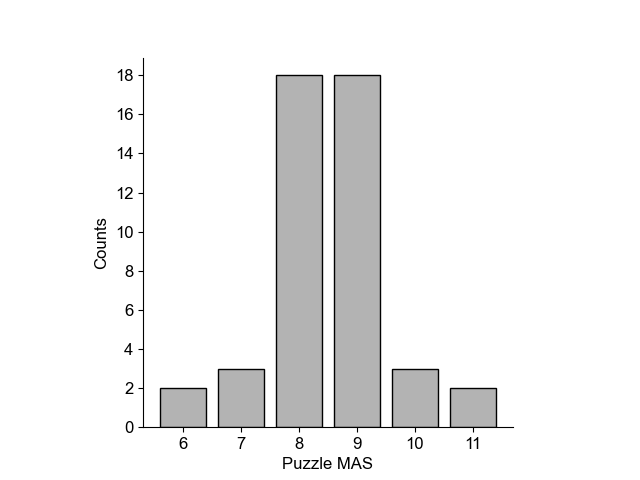

In [13]:
%matplotlib widget

n_mas = single_condition_data[single_condition_data.subjects==2].groupby(['mas'])['mas'].count() # only undo condition

fig, axs = plt.subplots(1, 1)
axs.bar(range(6,12), n_mas,
        color = (.7,.7,.7),
        edgecolor = 'k')## puzzle MAS

### histogram of MAS/remaining budget, numFullUndo',)
axs.set_ylabel('Counts') 
axs.set_yticks(list(range(0, 20, 2)))
axs.set_xlabel('Puzzle MAS')
# change size ratio to be 1:1
axs.set_aspect(1/axs.get_data_ratio(), adjustable='box')
#plt.show()
fig.savefig(out_dir + 'count_mas_puzzle.png', dpi=300, bbox_inches='tight')

# Undo - Error

In [14]:
# Assuming sc_data_choice_level is your DataFrame
undo_noerror = undo_data.loc[undo_data.cumulative_error == 0, :]
undo_error = undo_data.loc[undo_data.cumulative_error != 0, :]
undo_noerror_avg = undo_noerror.groupby("subjects")['firstUndo'].mean()
undo_error_avg = undo_error.groupby("subjects")['firstUndo'].mean()

print(len(undo_noerror_avg))
print(len(undo_error_avg))

move_undo_noerror = undo_data.loc[undo_data.severityOfErrors == 0, :]
move_undo_error = undo_data.loc[undo_data.severityOfErrors != 0, :]
move_undo_noerror_avg = move_undo_noerror.groupby("subjects")['firstUndo'].mean()
move_undo_error_avg = move_undo_error.groupby("subjects")['firstUndo'].mean()
print(len(move_undo_noerror_avg))
print(len(move_undo_error_avg))

100
100
100
100


## Binary error

### state/move Hit/falsealarm/balancedaccuracy 

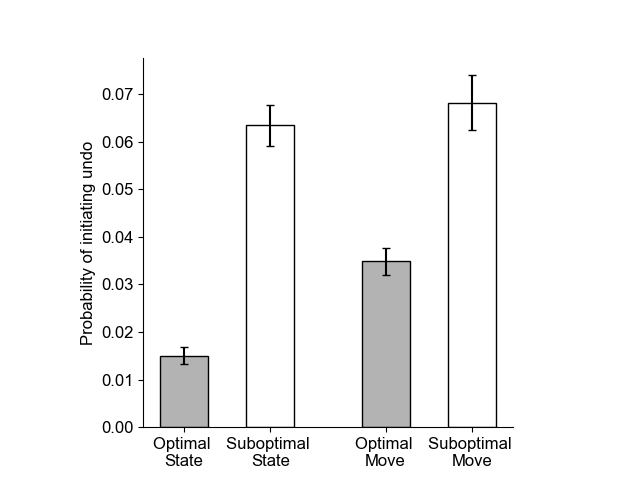

In [37]:
# This uses all undo
# plot in a scatter plot
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# box plot
# bx = axs.boxplot([undo_noerror_avg, undo_error_avg,
#              move_undo_noerror_avg, move_undo_error_avg],
#                 widths=0.5,
#                 positions =[1,1.9,3.1,4],
#                 patch_artist=True,
#                 showfliers=False,
#                 boxprops=dict(color='k'),
#                 whiskerprops=dict(color='k'),
#                 capprops=dict(color='k'),
#                 medianprops=dict(color='k'))

# colors = [(.7,.7,.7),'w',(.7,.7,.7),'w']
# for patch, color in zip(bx['boxes'], colors):
#     patch.set_facecolor(color)
positions = [1, 1.9, 3.1, 4]

mean_values = [undo_noerror_avg.mean(), undo_error_avg.mean(), move_undo_noerror_avg.mean(), move_undo_error_avg.mean()]

bars = axs.bar(positions,
               mean_values,
               width=0.5,
               color=[(.7, .7, .7), 'w', (.7, .7, .7), 'w'],
               edgecolor='k')

# add standard error
errs = axs.errorbar(positions,
                    mean_values,
                    yerr=[undo_noerror_avg.sem(), undo_error_avg.sem(), move_undo_noerror_avg.sem(), move_undo_error_avg.sem()],
                    fmt='none',  # No connecting line
                    capsize=3,  # Cap size for error bar
                    ecolor='k')  # Error bar color

axs.set_ylabel('Probability of initiating undo')
axs.set_xticks([1,1.9,3.1,4])
axs.set_xticklabels(labels = ['Optimal \nState',
                              'Suboptimal \nState',
                              'Optimal \nMove',
                              'Suboptimal \nMove'])#,fontsize=18

# set ratio to be 1:1
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir + 'undo_all_type.png', dpi=300, bbox_inches='tight')

##### statistics

In [38]:
#--------------------------------------
y_offset = 0.01
h = 0.001
# run 2-independent-sample t test
stat1, p1 = wilcoxon(undo_noerror_avg, undo_error_avg, alternative = 'less')
print(stat1, p1)
x1, x2 = positions[0:2]
y, col = max(mean_values[0:2]) + y_offset, 'k'
axs.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
text(p1)

#--------------------------------------
stat3, p3 = wilcoxon(move_undo_noerror_avg, move_undo_error_avg, alternative = 'less')
print(stat3, p3 )
x1, x2 = positions[2:4]
y, col = max(mean_values[2:4]) + y_offset, 'k'
axs.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
text(p3)
fig.savefig(out_dir + 'undo_all_type.png', dpi=600, bbox_inches='tight')

5.0 1.0313151189296478e-16
573.0 1.4878867567008786e-09


### steps Hit/false alarm 

#### suboptimal state

##### terminal or not

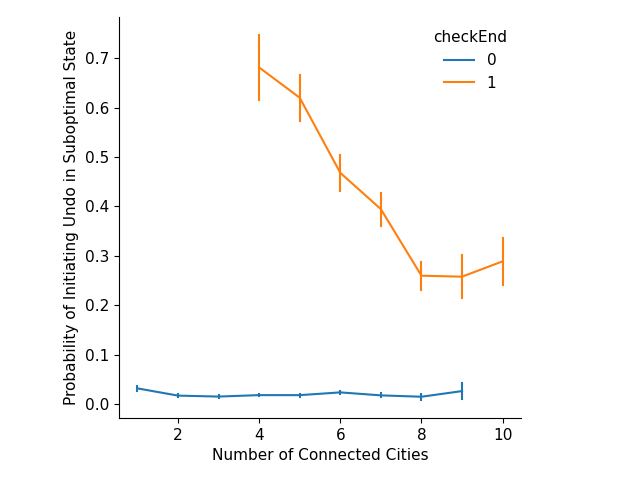

In [270]:
# This uses all undo
df_plot = undo_error.groupby(["subjects","checkEnd","currNumCities"])['undo'].mean().reset_index()
count_df = df_plot.groupby(["checkEnd","currNumCities"])['undo'].count().reset_index()
# filter df_plot if count_df > 10
df_plot = df_plot.merge(count_df, on = ["checkEnd","currNumCities"], how = "left", suffixes = ("","_count"))
df_plot = df_plot[df_plot['undo_count'] > 30]
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='currNumCities', y='undo', 
             hue = "checkEnd", 
        #      color = "k",
             data = df_plot, 
             errorbar = "se",
             err_style = "bars")
# axs.set_yticks(np.linspace(0,0.2,5))
# axs.set_ylim([0,0.2])
axs.set(xlabel='Number of Connected Cities', 
        ylabel='Probability of Initiating Undo in Suboptimal State')
# set legend title
axs.legend(title = "checkEnd", frameon=False, loc='upper right')
axs.set_aspect(1/axs.get_data_ratio())
plt.tight_layout()
fig.savefig(out_dir+'undo_error_step_terminal.png', dpi=300, bbox_inches='tight')

#### optimal state

##### allMAS

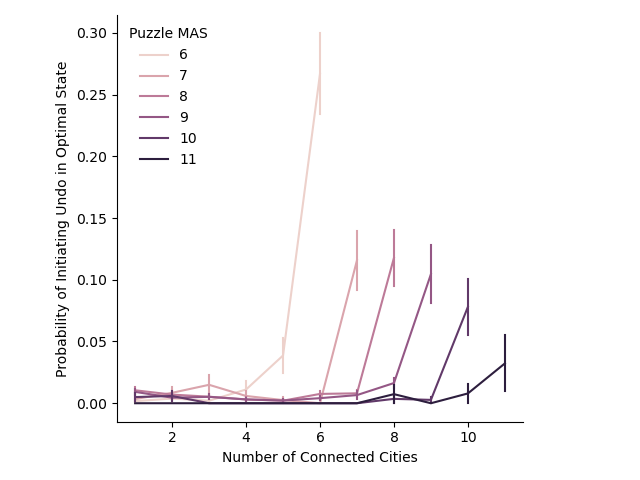

In [17]:
# This uses all undo
df_plot = undo_noerror.groupby(["subjects","allMAS", "currNumCities"])['undo'].mean().reset_index()
count_df = df_plot.groupby(["allMAS","currNumCities"])['undo'].count().reset_index()
# filter df_plot if count_df > 10
df_plot = df_plot.merge(count_df, on = ["allMAS","currNumCities"], how = "left", suffixes = ("","_count"))
df_plot = df_plot[df_plot['undo_count'] > 30]
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='currNumCities', y='undo', 
             hue = "allMAS", 
             data = df_plot, 
             errorbar = "se",
             err_style = "bars")
# axs.set_yticks(np.linspace(0,0.2,5))
# axs.set_ylim([0,0.2])
axs.set(xlabel='Number of Connected Cities', 
        ylabel='Probability of Initiating Undo in Optimal State')
# set legend title
axs.legend(title = "Puzzle MAS", frameon=False, loc='upper left')
axs.set_aspect(1/axs.get_data_ratio())
plt.tight_layout()
fig.savefig(out_dir+'undo_noerror_step.png', dpi=300, bbox_inches='tight')

##### terminal or not

In [19]:
# This uses all undo
df_plot = undo_noerror.groupby(["subjects","checkEnd", "currNumCities"])['undo'].mean().reset_index()
count_df = df_plot.groupby(["checkEnd","currNumCities"])['undo'].count().reset_index()
# filter df_plot if count_df > 10
df_plot = df_plot.merge(count_df, on = ["checkEnd","currNumCities"], how = "left", suffixes = ("","_count"))
df_plot = df_plot[df_plot['undo_count'] > 30]
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='currNumCities', y='undo', 
             hue = "checkEnd", 
             data = df_plot, 
             errorbar = "se",
             err_style = "bars")
# axs.set_yticks(np.linspace(0,0.2,5))
# axs.set_ylim([0,0.2])
axs.set(xlabel='Number of Connected Cities', 
        ylabel='Probability of Initiating Undo in Optimal State')
# set legend title
axs.legend(title = "checkEnd", frameon=False, loc='upper left')
axs.set_aspect(1/axs.get_data_ratio())
plt.tight_layout()
fig.savefig(out_dir+'undo_noerror_step.png', dpi=300, bbox_inches='tight')

NameError: name 'undo_noerror' is not defined

### balanced accuracy correlation with basic condition

#### state-level

In [17]:
# This uses all undo
TNR = 1 - undo_noerror_avg # True Negative Rate 
balanced_accuracy = (undo_error_avg + TNR)/2

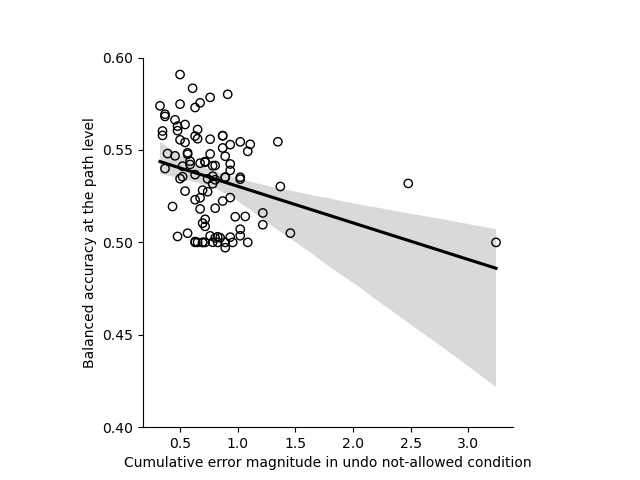

In [21]:
score = puzzleID_order_data[puzzleID_order_data['condition']==0].groupby(['subjects'])['sumSeverityErrors'].mean()

# plot the correlation
fig, axs = plt.subplots(1, 1)

axs.scatter( score, balanced_accuracy,               
             edgecolor="black",
                facecolor="None")
# add regplot line
sns.regplot(x=score, y=balanced_accuracy, ax=axs, ci=95, scatter=False, color='black')

# set yticks
axs.set_yticks(np.arange(0.4, 0.65, 0.05))

axs.set_xlabel('Cumulative error magnitude in undo not-allowed condition')
axs.set_ylabel('Balanced accuracy at the path level') #Difference in undo initiation probability \nbetween optimal and suboptimal paths

axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir + 'path_balanced_acc_correlation.png', dpi=300, bbox_inches='tight')

In [22]:
# correlation between efficiency and score
spearmanr(score, balanced_accuracy)

SpearmanrResult(correlation=-0.38182817993772894, pvalue=8.85945768963304e-05)

#### move-level

In [18]:
move_TNR = 1 - move_undo_noerror_avg # True Negative Rate 
balanced_accuracy_move = (move_undo_error_avg + move_TNR)/2

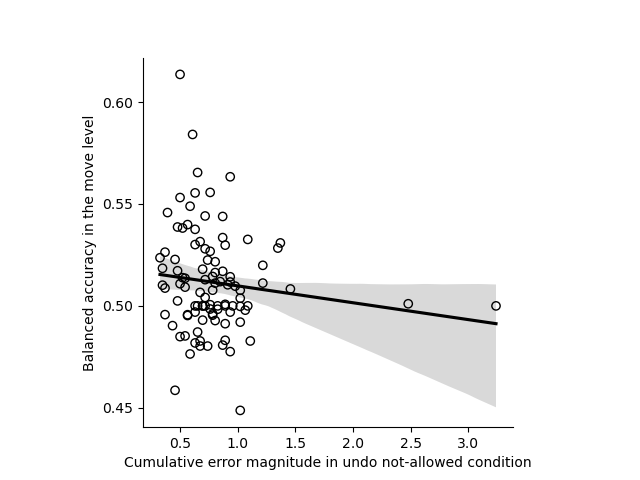

In [24]:
score = puzzleID_order_data[puzzleID_order_data['condition']==0].groupby(['subjects'])['sumSeverityErrors'].mean()

# plot the correlation
fig, axs = plt.subplots(1, 1)

axs.scatter( score, balanced_accuracy_move,               
             edgecolor="black",
             facecolor="None")
axs.set_yticks(np.arange(0.4, 0.65, 0.05))

# add regplot line
sns.regplot(x=score, y=balanced_accuracy_move, ax=axs, ci=95, scatter=False, color='black')

axs.set_xlabel('Cumulative error magnitude in undo not-allowed condition')
axs.set_ylabel('Balanced accuracy in the move level') # Difference in undo initiation probability \nbetween optimal and suboptimal moves

axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir + 'move_balanced_acc_correlation.png', dpi=300, bbox_inches='tight')

In [25]:
# correlation between efficiency and score
spearmanr(score, balanced_accuracy_move)

SpearmanrResult(correlation=-0.13378809589916837, pvalue=0.18449713269822837)

## Error magnitude

### state-level error

#### Probability, all

In [33]:
undo_data_avg = undo_data.groupby(["subjects","cumulative_error"])["firstUndo"].mean().reset_index()
undo_data_avg.groupby(["cumulative_error"])["firstUndo"].count()

cumulative_error
0    100
1    100
2    100
3     81
4     42
5      8
6      3
8      1
Name: firstUndo, dtype: int64

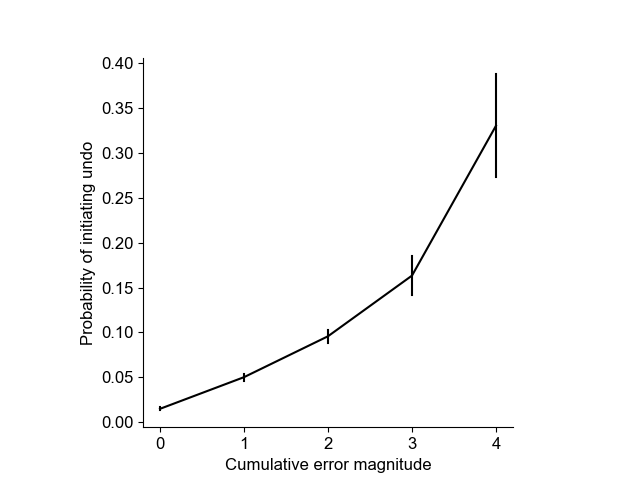

In [36]:
# This uses all undo
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='cumulative_error', y='firstUndo', 
             data = undo_data_avg[undo_data_avg.cumulative_error<=4],
             color = 'k',
             err_style = "bars",
             errorbar = "se")

axs.set_xticks([0,1,2,3,4])
# axs.set_ylim(0,0.15)
axs.set(xlabel='Cumulative error magnitude', ylabel='Probability of initiating undo')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'undo_cumulative_error_magnitude.png', dpi=300, bbox_inches='tight')

##### statistics

In [36]:
%%R 
model_undo = lme4::glmer(firstUndo ~  1 + cumulative_error  + (1 |subjects),
                                  data = undo_data, family = "binomial")
save(model_undo, undo_data, file=file.path(out_dir2, file=paste("model_undo_cumulative_error.RData", sep="")))
summary(model_undo)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: firstUndo ~ 1 + cumulative_error + (1 | subjects)
   Data: undo_data

     AIC      BIC   logLik deviance df.resid 
 17679.7  17706.0  -8836.8  17673.7    47227 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.3172 -0.2564 -0.1728 -0.1052 17.1219 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 1.769    1.33    
Number of obs: 47230, groups:  subjects, 100

Fixed effects:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -4.29558    0.14247  -30.15   <2e-16 ***
cumulative_error  0.90912    0.02234   40.70   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
cumultv_rrr -0.194


#### Probability, terminal or non-terminal

In [23]:
undo_data_end_avg = undo_data.groupby(["subjects","cumulative_error", "checkEnd"])["undo"].mean().reset_index()
undo_data_end_avg.groupby(["cumulative_error", "checkEnd"])["undo"].count()

cumulative_error  checkEnd
0                 0           100
                  1            99
1                 0           100
                  1            99
2                 0           100
                  1           100
3                 0            78
                  1            79
4                 0            37
                  1            37
5                 0             7
                  1             7
6                 0             3
                  1             1
8                 1             1
Name: undo, dtype: int64

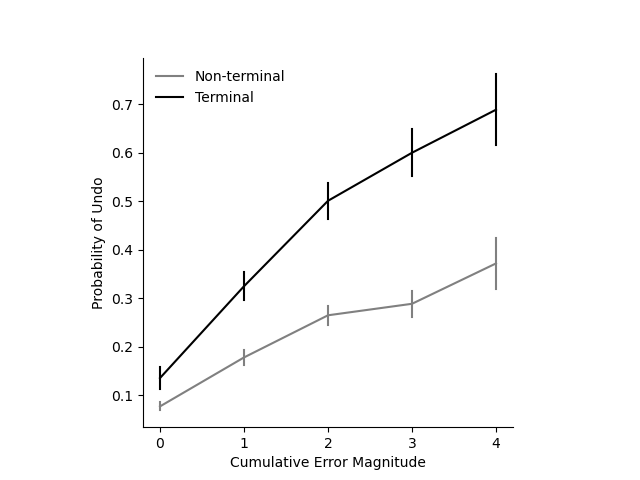

In [24]:
# This uses all undo
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='cumulative_error', y='undo', 
             data = undo_data_end_avg[undo_data_end_avg.cumulative_error<5], 
             hue = "checkEnd",
             palette = ["grey","k"],
             err_style = "bars",
             errorbar = "se")

plt.legend(labels=['Non-terminal','Terminal'], loc='upper left')

axs.set_xticks([0,1,2,3,4])
# axs.set_ylim(0,0.15)

axs.set(xlabel='Cumulative Error Magnitude', ylabel='Probability of Undo')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
# fig.savefig(out_dir+'undo_terminal_cumulative_error.png', dpi=300, bbox_inches='tight')

##### statistics

In [48]:
%%R 
model_undo = lme4::glmer(firstUndo ~  1 + cumulative_error*checkEnd  + (1 |subjects),
                                  data = undo_data, family = "binomial")
save(model_undo, undo_data, file=file.path(out_dir2, file=paste("model_undo_cumulative_error_checkEnd.RData", sep="")))
summary(model_undo)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: firstUndo ~ 1 + cumulative_error * checkEnd + (1 | subjects)
   Data: undo_data

     AIC      BIC   logLik deviance df.resid 
 11328.3  11372.1  -5659.2  11318.3    47225 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-9.503 -0.145 -0.092 -0.044 51.363 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 3.687    1.92    
Number of obs: 47230, groups:  subjects, 100

Fixed effects:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)               -6.01574    0.20912  -28.77   <2e-16 ***
cumulative_error           0.66099    0.04337   15.24   <2e-16 ***
checkEnd                   3.30307    0.07644   43.21   <2e-16 ***
cumulative_error:checkEnd  0.61875    0.06140   10.08   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            

### move-level error

#### Probability, terminal or non-terminal

In [30]:
allUndo_sub = undo_data.groupby(['subjects','severityOfErrors'])['firstUndo'].mean().reset_index()
nonterminalUndo_sub = undo_data.groupby(['subjects','severityOfErrors'])['nonterminal_undo'].mean().reset_index()
terminalUndo_sub = undo_data.groupby(['subjects','severityOfErrors'])['terminal_undo'].mean().reset_index()
print(allUndo_sub.groupby(['severityOfErrors'])['subjects'].count().reset_index())

   severityOfErrors  subjects
0                 0       100
1                 1       100
2                 2        98
3                 3        65
4                 4        22
5                 5         3
6                 6         3


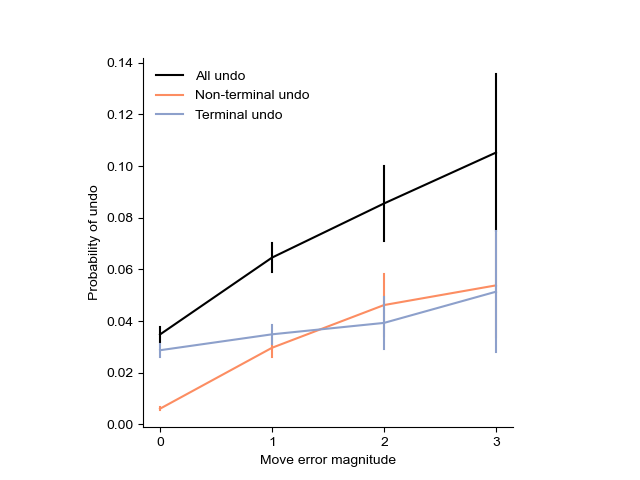

In [31]:
# This uses all undo
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='severityOfErrors', y='firstUndo', 
             data = allUndo_sub[allUndo_sub.severityOfErrors<=3], 
             color = 'k', #
             err_style = "bars",
             errorbar = "se")
sns.lineplot(x='severityOfErrors', y='nonterminal_undo',
             data = nonterminalUndo_sub[nonterminalUndo_sub.severityOfErrors<=3],
             color = '#fc8d62',
             err_style = "bars",
             errorbar = "se")
sns.lineplot(x='severityOfErrors', y='terminal_undo',
                data = terminalUndo_sub[terminalUndo_sub.severityOfErrors<=3],
                color = '#8da0cb',
                err_style = "bars",
                errorbar = "se")

# add manual legend
plt.legend(labels=['All undo','Non-terminal undo','Terminal undo'], loc='upper left')

axs.set_xticks([0,1,2,3])
# axs.set_ylim(0,0.15)

axs.set(xlabel='Move error magnitude', ylabel='Probability of undo')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'terminal_error_magnitude.png', dpi=300, bbox_inches='tight')

##### statistics

In [57]:
%%R 
model_undo = lme4::glmer(firstUndo ~  1 + severityOfErrors  + (1 |subjects),
                                  data = undo_data, family = "binomial")
save(model_undo, undo_data, file=file.path(out_dir2, file=paste("model_undo_error_magnitude.RData", sep="")))
print(summary(model_undo))

model_undo = lme4::glmer(sequential_undo ~  1 + severityOfErrors + (1 |subjects),
                                  data = undo_data, family = "binomial")
save(model_undo, undo_data, file=file.path(out_dir2, file=paste("model_sequential_undo_error_magnitude.RData", sep="")))
print(summary(model_undo))

model_undo = lme4::glmer(single_undo ~  1 + severityOfErrors + (1 |subjects),
                                  data = undo_data, family = "binomial")
save(model_undo, undo_data, file=file.path(out_dir2, file=paste("model_single_undo_error_magnitude.RData", sep="")))
print(summary(model_undo))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: firstUndo ~ 1 + severityOfErrors + (1 | subjects)
   Data: undo_data

     AIC      BIC   logLik deviance df.resid 
 19246.8  19273.1  -9620.4  19240.8    47227 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.6700 -0.2819 -0.2280 -0.1184 13.0270 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 1.414    1.189   
Number of obs: 47230, groups:  subjects, 100

Fixed effects:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -3.51328    0.12674 -27.720  < 2e-16 ***
severityOfErrors  0.26733    0.04371   6.117 9.55e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
svrtyOfErrr -0.059


#### Proportion, sequential or single, mapMAS

In [64]:
singleUndo_sub = only_undo_df.groupby(['subjects','severityOfErrors','allMAS'])['single_undo'].mean().reset_index()
singleUndo_sub.groupby(['severityOfErrors','allMAS'])['subjects'].count().reset_index()

,severityOfErrors,allMAS,subjects
0,0,6,56
1,0,7,64
2,0,8,82
3,0,9,78
4,0,10,40
5,0,11,39
6,1,6,12
7,1,7,20
8,1,8,48
9,1,9,56


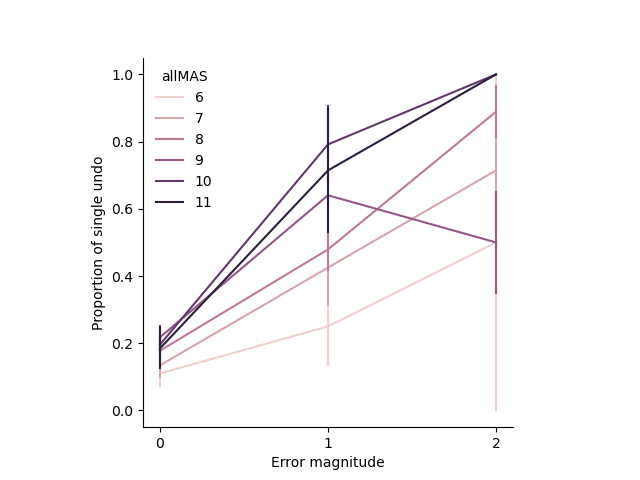

In [63]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
lineplot = sns.lineplot(x='severityOfErrors', y='single_undo', 
             data = singleUndo_sub[singleUndo_sub.severityOfErrors<=2], 
             hue = "allMAS",
             color = 'k',
             err_style = "bars",
             errorbar = "se")
axs.set_xticks([0,1,2])
axs.set_yticks([0,0.2,0.4,0.6,0.8,1])

n_sub = singleUndo_sub[singleUndo_sub.severityOfErrors<=2].groupby(['severityOfErrors'])['subjects'].count().reset_index()
# add each n_sub to each dot on the line,  y uses the position of each dot
# loop through lineplot dots
# for i in range(len(n_sub)):
#     # add text to lineplot
#     lineplot.text(x = n_sub.severityOfErrors[i], # x-coordinate position of data label, padded to be right of the scatterplot
#                   y = singleUndo_sub[singleUndo_sub.severityOfErrors<=2].groupby(['severityOfErrors'])['singleUndo'].mean()[i]+0.1, # y-coordinate position of data label, padded to be above scatterplot
#                   s = "N="+str(n_sub.subjects[i]), # data label, formatted to ignore decimals
#                   color = 'black') # set colour of line


#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
axs.set(xlabel='Error magnitude', ylabel='Proportion of single undo')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'prop_single_error_magnitude.png', dpi=300, bbox_inches='tight')

In [65]:
%%R -i only_undo_df,out_dir2
only_undo_df$subjects <- as.factor(only_undo_df[,"subjects"])

# lambda = 0.33
# error_undo_df$severityOfErrors_lamda <- (error_undo_df$severityOfErrors^lambda-1)/lambda
model_undo = lme4::glmer(single_undo ~  1 + severityOfErrors + (1 |subjects),
                                  data = only_undo_df, family = "binomial")

save(model_undo, only_undo_df, file=file.path(out_dir2, file=paste("model_prop_single_undo_error_magnitude.RData", sep="")))
summary(model_undo)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: single_undo ~ 1 + severityOfErrors + (1 | subjects)
   Data: only_undo_df

     AIC      BIC   logLik deviance df.resid 
  2076.2   2093.8  -1035.1   2070.2     2657 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-10.5690  -0.3739  -0.3001  -0.2164   5.1250 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 1.981    1.407   
Number of obs: 2660, groups:  subjects, 90

Fixed effects:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -1.7879     0.1756  -10.18   <2e-16 ***
severityOfErrors   1.7452     0.1272   13.71   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
svrtyOfErrr -0.198


# Undo - state features

## number of cities

#### optimality, only terminal

In [92]:
firstUndo_sub = undo_data[undo_data.checkEnd==1].groupby(['subjects','currNumCities','suboptimal_state'])['undo'].mean().reset_index()
# firstUndo_sub.groupby(['currNumCities','error'])['firstUndo'].count()

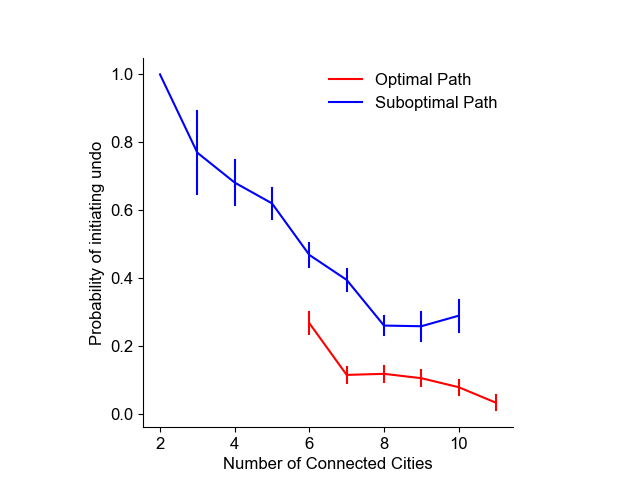

In [93]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='currNumCities', y='undo', 
             data = firstUndo_sub,
             hue = 'suboptimal_state',
             palette = ['red','blue'],
             err_style = "bars",
             errorbar = "se")
# add manual legend
plt.legend(labels=['Optimal Path','Suboptimal Path'], loc='upper right')
axs.set(xlabel='Number of Connected Cities', ylabel='Probability of initiating undo')
axs.set_aspect(1/axs.get_data_ratio())
# fig.savefig(out_dir+'undo_currNumCities.png', dpi=300, bbox_inches='tight')
plt.show()

### terminal 

In [95]:
firstUndo_sub = undo_data.groupby(['subjects','currNumCities',"checkEnd"])['firstUndo'].mean().reset_index()
count_df = firstUndo_sub.groupby(["currNumCities","checkEnd"])['firstUndo'].count().reset_index()
firstUndo_sub = firstUndo_sub.merge(count_df, on = ["currNumCities","checkEnd"], how = "left", suffixes = ("","_count"))
# firstUndo_sub = firstUndo_sub[firstUndo_sub['firstUndo_count'] > 30]

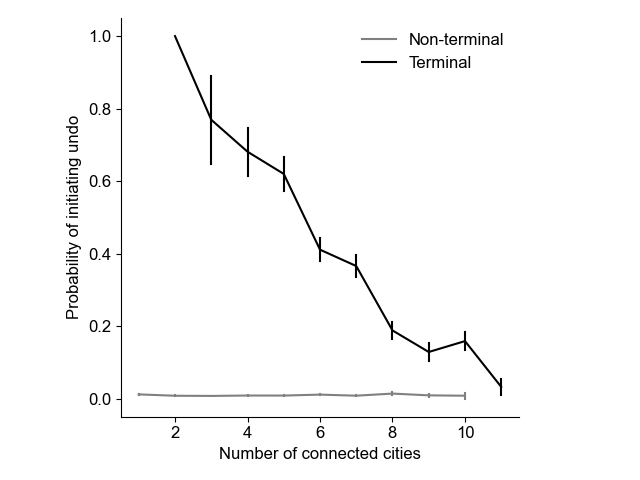

In [98]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='currNumCities', y='firstUndo', 
             hue = "checkEnd", 
             data = firstUndo_sub,
             errorbar = "se",
             err_style = "bars",
             palette = ['grey','k']
             )
axs.set(xlabel='Number of connected cities', 
        ylabel='Probability of initiating undo')
# set legend title
axs.legend(labels=['Non-terminal','Terminal'], frameon=False, loc='upper right')
axs.set_aspect(1/axs.get_data_ratio())
plt.tight_layout()
fig.savefig(out_dir+'undo_step_terminal.png', dpi=300, bbox_inches='tight')

#### statistics

In [92]:
%%R 
model_undo = glm(firstUndo ~  1 + currNumCities * checkEnd + (1 |subjects),
                                  data = undo_data, family = binomial())
save(model_undo, undo_data, file=file.path(out_dir2, file=paste("model_undo_step_checkEnd.RData", sep="")))
summary(model_undo)


Call:
glm(formula = firstUndo ~ 1 + currNumCities * checkEnd + (1 | 
    subjects), family = binomial(), data = undo_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0017  -0.1527  -0.1492  -0.1458   3.0242  

Coefficients: (1 not defined because of singularities)
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             -4.58586    0.09318 -49.214   <2e-16 ***
currNumCities            0.02340    0.02051   1.141    0.254    
checkEnd1                8.19851    0.19646  41.731   <2e-16 ***
1 | subjectsTRUE              NA         NA      NA       NA    
currNumCities:checkEnd1 -0.60814    0.03108 -19.564   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 21549  on 57532  degrees of freedom
Residual deviance: 13578  on 57529  degrees of freedom
AIC: 13586

Number of Fisher Scoring iterations: 7



### Across N_more

In [19]:
firstUndo_sub = undo_data.groupby(['subjects','N_more'])['undo'].mean().reset_index()

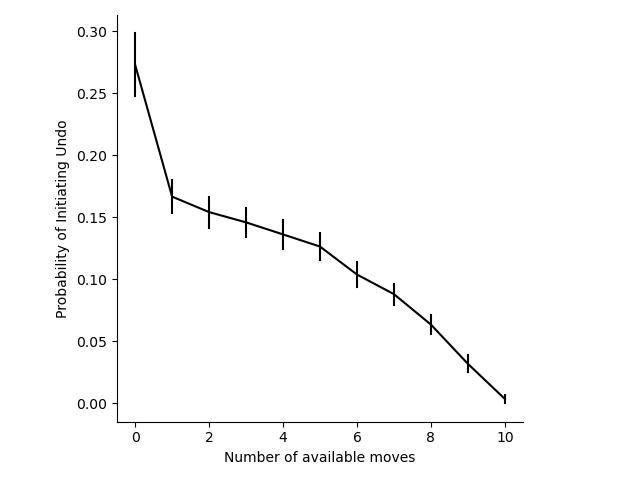

In [20]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='N_more', y='undo', 
        #      hue = "allMAS", 
             color = 'k',
             data = firstUndo_sub,
             errorbar = "se",
             err_style = "bars"
             #palette = ['red','blue']
             )
# axs.set_yticks(np.linspace(0,0.2,5))
# axs.set_ylim([0,0.2])
axs.set(xlabel='Number of available moves', 
        ylabel='Probability of Initiating Undo')
# set legend title
# axs.legend(title = "Puzzle MAS", frameon=False, loc='upper right')
axs.set_aspect(1/axs.get_data_ratio())
plt.tight_layout()
# fig.savefig(out_dir+'undo_nmore.png', dpi=300, bbox_inches='tight')

### Puzzle MAS

In [99]:
firstUndo_sub = undo_data.groupby(['subjects','allMAS','checkEnd'])['firstUndo'].mean().reset_index()
# firstUndo_sub.groupby(['allMAS','checkEnd'])['firstUndo'].count()

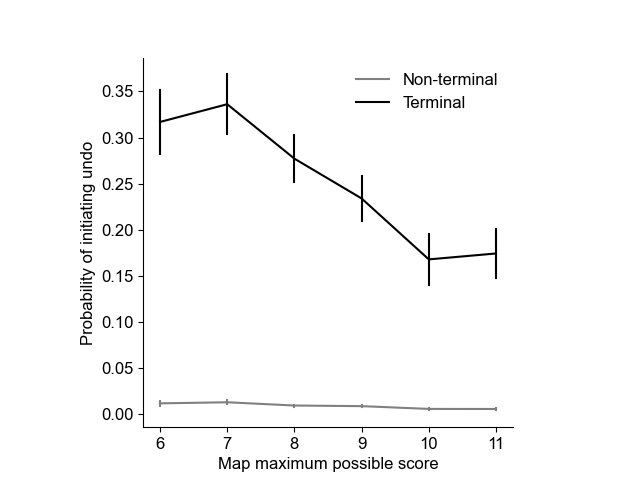

In [104]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='allMAS', y='firstUndo', 
             data = firstUndo_sub, #[firstUndo_sub.checkEnd==1]
             hue = 'checkEnd',
             palette = ['grey','k'],
             err_style = "bars",
             errorbar = "se")
# add manual legend
axs.legend(labels=['Non-terminal','Terminal'], frameon=False, loc='upper right')
# hide legend
# axs.get_legend().remove()
axs.set(xlabel='Map maximum possible score', ylabel='Probability of initiating undo')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'undo_MAS.png', dpi=300, bbox_inches='tight')
plt.show()

### proportion, sequential undo - terminal/non-terminal

In [21]:
sequentialUndo_sub = only_undo_df.groupby(['subjects','checkEnd'])['sequential_undo'].mean().reset_index()

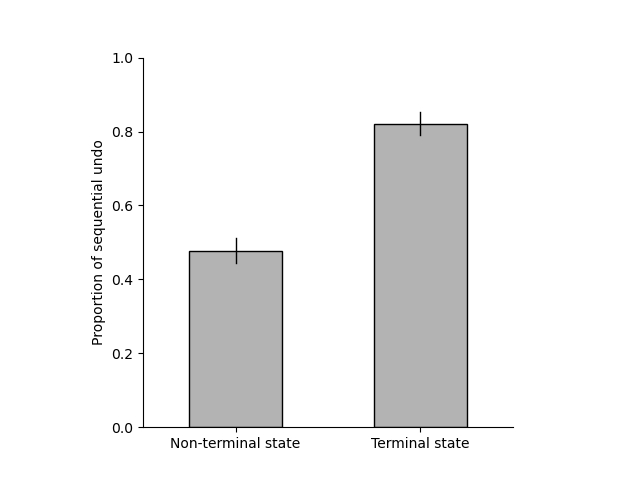

In [22]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.barplot(x='checkEnd', y='sequential_undo', 
            data = sequentialUndo_sub, 
            color= [0.7,0.7,0.7],
            edgecolor = ['k','k','k'],
            width=.5,
            linewidth=1,
            errcolor = 'k',
            errwidth = 1,
            errorbar = "se")

axs.set_xticklabels(labels = [ "Non-terminal state" , "Terminal state"])#,fontsize=18

# # add text on the upper of each bar 
# for x, y, n in zip([0,1], sequentialUndo_sub.groupby(['checkEnd'])['sequential_undo'].mean(), n_sub.sequentialUndo):
#     axs.text(x, y+0.05, "N = " + str(n), ha='center', va='bottom', fontsize=12)

axs.set_yticks(np.linspace(0,1,6))
#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
axs.set(xlabel = '', ylabel='Proportion of sequential undo')
axs.set_aspect(1/axs.get_data_ratio(), adjustable='box')

fig.savefig(out_dir+'sequential_terminal.png', dpi=300, bbox_inches='tight')

#### statistics

In [23]:
stat1, p1 = mannwhitneyu(np.array(sequentialUndo_sub.loc[(sequentialUndo_sub.checkEnd==1),'sequential_undo']), 
                     np.array(sequentialUndo_sub.loc[(sequentialUndo_sub.checkEnd==0),'sequential_undo'])) 
# axs.set_title(r"$p = {0:s}$".format(as_si(p1,1)))
print(stat1, p1)

5423.0 2.194581026983643e-12


## Remaining budget

In [105]:
firstUndo_sub = undo_data.groupby(['subjects','leftover_bin', 'checkEnd'])['firstUndo'].mean().reset_index()
count_df = firstUndo_sub.groupby(['leftover_bin', 'checkEnd'])['firstUndo'].count()
# firstUndo_sub = firstUndo_sub.merge(count_df, on = ["leftover_bin","checkEnd"], how = "left", suffixes = ("","_count"))
# firstUndo_sub = firstUndo_sub[firstUndo_sub['firstUndo_count'] > 30]

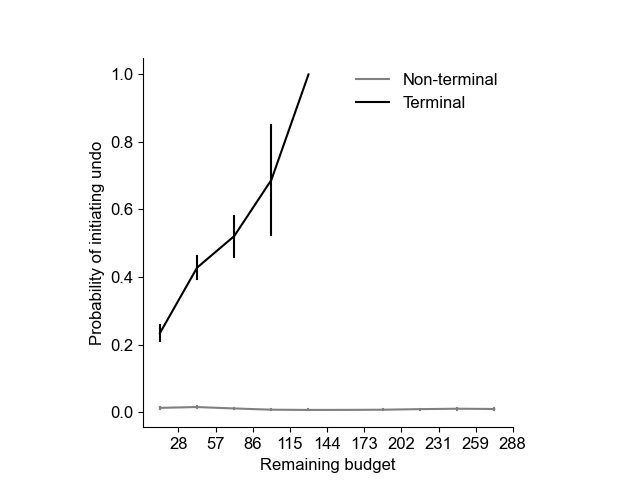

In [106]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='leftover_bin', y='firstUndo', 
             data = firstUndo_sub,
             hue = 'checkEnd',
             palette = ['grey','k'],
             err_style = "bars",
             errorbar = "se")
# use cutoff to set x ticklabels
axs.set_xticks(np.arange(0.5, 10.5, 1))
axs.set_xticklabels(cutoff_budget[1:].astype(int))
axs.legend(labels=['Non-terminal','Terminal'], frameon=False, loc='upper right')
axs.set(xlabel='Remaining budget', ylabel='Probability of initiating undo')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'undo_budget.png', dpi=300, bbox_inches='tight')
plt.show()

## Efficiency

## Budget change

In [30]:
firstUndo_sub = undo_data.groupby(['subjects','budget_change_bin', 'N_more'])['firstUndo'].mean().reset_index()
count_df = firstUndo_sub.groupby(['budget_change_bin', 'N_more'])['firstUndo'].count()
# firstUndo_sub = firstUndo_sub.merge(count_df, on = ["budget_change_bin","checkEnd"], how = "left", suffixes = ("","_count"))
# firstUndo_sub = firstUndo_sub[firstUndo_sub['firstUndo_count'] > 30]

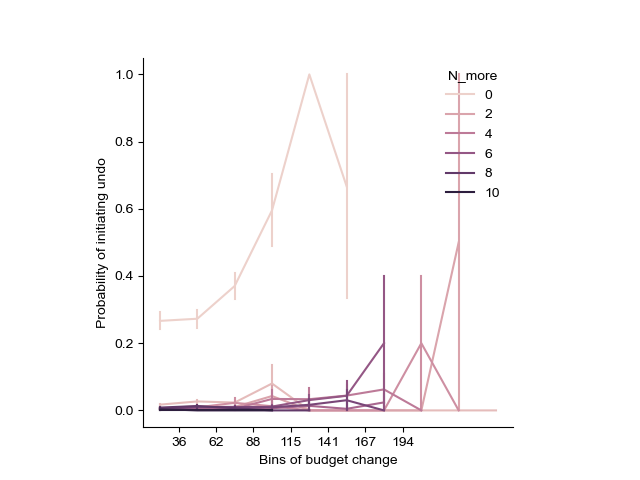

In [33]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='budget_change_bin', y='firstUndo', 
             data = firstUndo_sub,
             hue = 'N_more',
            #  palette = ['grey','k'],
             err_style = "bars",
             errorbar = "se")
#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
# use cutoff to set x ticklabels
axs.set_xticks(np.arange(0.5, 7.5, 1))
axs.set_xticklabels(cutoff_budgetchange[1:8].astype(int))
# axs.legend(labels=['Non-terminal','Terminal'], frameon=False, loc='upper right')
axs.set(xlabel='Bins of budget change', ylabel='Probability of initiating undo')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'undo_budgetchange_terminal.png', dpi=300, bbox_inches='tight')
plt.show()

## Within reach change

In [112]:
# plot undo across leftover_bin
firstUndo_sub = undo_data.groupby(['subjects','within_reach_change_bin','checkEnd'])['firstUndo'].mean().reset_index()
count_df = firstUndo_sub.groupby(['within_reach_change_bin', 'checkEnd'])['firstUndo'].count()
firstUndo_sub = firstUndo_sub.merge(count_df, on = ["within_reach_change_bin","checkEnd"], how = "left", suffixes = ("","_count"))
firstUndo_sub = firstUndo_sub[firstUndo_sub['firstUndo_count'] > 30]

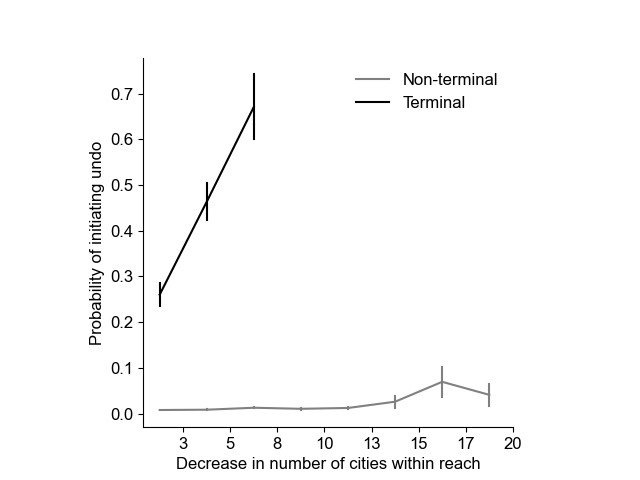

In [113]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot
sns.lineplot(x='within_reach_change_bin', y='firstUndo', 
             data = firstUndo_sub,
             hue = "checkEnd",
             palette = ['grey','k'],
            #  color = 'k',
             err_style = "bars",
             errorbar = "se")
axs.set_xticks(np.arange(0.5, 8.5, 1))
axs.set_xticklabels(cutoff_withinreachchange[1:9].astype(int))
axs.legend(labels=['Non-terminal','Terminal'], frameon=False, loc='upper right')
axs.set(xlabel='Decrease in number of cities within reach', ylabel='Probability of initiating undo')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'undo_withinreach_change_terminal.png', dpi=300, bbox_inches='tight')

# Errors

In [79]:
# error as a state instead of a type of move
def get_error_data(df):
    condition = f"(submit != 1) & (currNumCities != 0)"
    index = df.query(condition).index

    undo_data = df.loc[index, ["subjects","puzzleID","error","severityOfErrors", "cumulative_error","undo","allMAS","currNumCities","N_more", "checkEnd",'leftover', "within_reach",'budget_change', 'within_reach_change']]
    undo_data = undo_data.loc[undo_data.undo != 1,:] # restrict actions to only moves
    temp, cutoff_budget = pd.cut(undo_data['leftover'], 10 , labels = False, retbins=True, precision = 1)
    undo_data["leftover_bin"] = temp
    temp, cutoff_budgetchange = pd.cut(undo_data['budget_change'], 10 , labels = False, retbins=True, precision = 1)
    undo_data["budget_change_bin"] = temp
    temp, cutoff_withinreachchange = pd.cut(undo_data['within_reach_change'], 10 , labels = False, retbins=True, precision = 1, duplicates='drop')
    undo_data["within_reach_change_bin"] = temp
    return undo_data, np.around(cutoff_budget, 1), np.around(cutoff_budgetchange, 1), np.around(cutoff_withinreachchange, 1)

data_cond0_outcome, _,_,_ = get_error_data(data_choice_level[(data_choice_level['condition']==0)])
data_cond1_outcome, cutoff_budget,cutoff_budgetchange,cutoff_withinreachchange = get_error_data(sc_data_choice_level)

In [23]:
%%R -i data_cond0_outcome,data_cond1_outcome,out_dir2
data_cond0_outcome$subjects <- as.factor(data_cond0_outcome[,"subjects"])
data_cond0_outcome$allMAS <- as.factor(data_cond0_outcome[,"allMAS"])
data_cond1_outcome$subjects <- as.factor(data_cond1_outcome[,"subjects"])
data_cond1_outcome$allMAS <- as.factor(data_cond1_outcome[,"allMAS"])

data_cond1_outcome$currNumCities_new <- scale(data_cond1_outcome[,"currNumCities"])
data_cond1_outcome$leftover_new <- scale(data_cond1_outcome[,"leftover"])
data_cond1_outcome$within_reach_new <- scale(sqrt(data_cond1_outcome[,"within_reach"]))
data_cond1_outcome$budget_change_new <- scale(data_cond1_outcome[,"budget_change"])
data_cond1_outcome$within_reach_change_new <- scale(data_cond1_outcome[,"within_reach_change"])

# save undo_data
write.csv(data_cond1_outcome, file = paste0(data_dir, "error_data_undo_condition.csv"), row.names = F)

## number of cities

### Basic condition (supp)

In [93]:
error_sub = data_cond0_outcome.groupby(['subjects','currNumCities'])['error'].mean().reset_index()
# count number of subjects in each prevNumCities and allMAS
# error_sub.groupby(['prevNumCities',"allMAS"])['error'].count().reset_index()

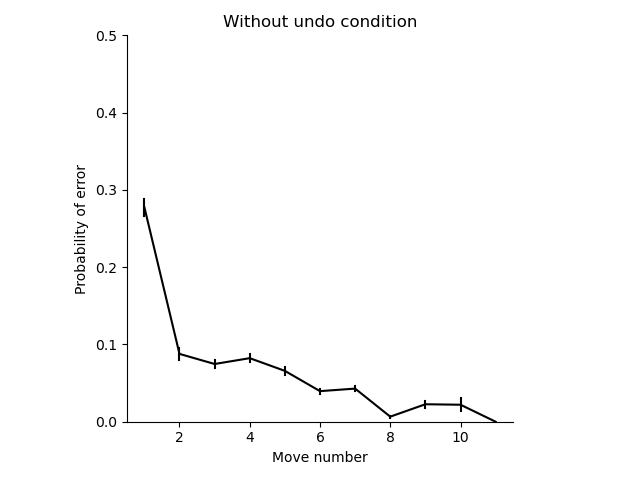

In [94]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)
# select error_sub when allMAS is 9 or 10
sns.lineplot(x='currNumCities', y='error', 
            #  hue = "allMAS", 
             color = "k",
             data = error_sub, 
             errorbar = "se",
             err_style = "bars")
axs.set(xlabel='Move number', ylabel='Probability of error')
axs.set_ylim(0,0.5)
# axs.legend(title = "Puzzle MAS", 
            #   frameon=False)
axs.set_title("Without undo condition")
axs.set_aspect(1/axs.get_data_ratio())
plt.tight_layout()
fig.savefig(out_dir+'error_step_basic_condition.png', dpi=300, bbox_inches='tight')

##### statistics

In [ ]:
%%R -i
model_error = lme4::glmer(error ~  1 + currNumCities + (1 |subjects),
                                  data = data_cond0_outcome, family = "binomial")
save(model_error, data_cond0_outcome, file=file.path(out_dir2, file=paste("model_error_step_basic_condition.RData", sep="")))
summary(model_error)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: error ~ 1 + prevNumCities + allMAS + (1 | subjects)
   Data: 
data_cond0_outcome[(data_cond0_outcome$allMAS == 8) | (data_cond0_outcome$allMAS ==  
    9), ]

     AIC      BIC   logLik deviance df.resid 
 14572.4  14605.3  -7282.2  14564.4    27387 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.0427 -0.3540 -0.2325 -0.1478  8.7125 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 0.1166   0.3415  
Number of obs: 27391, groups:  subjects, 100

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -1.42462    0.05214  -27.32  < 2e-16 ***
prevNumCities -0.40420    0.01198  -33.73  < 2e-16 ***
allMAS9        0.16285    0.04450    3.66 0.000252 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) prvNmC
prevNumCits -

### Undo condition

#### cumulative error

In [84]:
error_sub = data_cond1_outcome.groupby(['subjects','currNumCities','checkEnd'])['cumulative_error'].mean().reset_index()
count_df = error_sub.groupby(['currNumCities','checkEnd'])['cumulative_error'].count().reset_index()
# error_sub = error_sub.merge(count_df, on = ["currNumCities","checkEnd"], how = "left", suffixes = ("","_count"))
# error_sub = error_sub[error_sub['cumulative_error_count'] > 30]

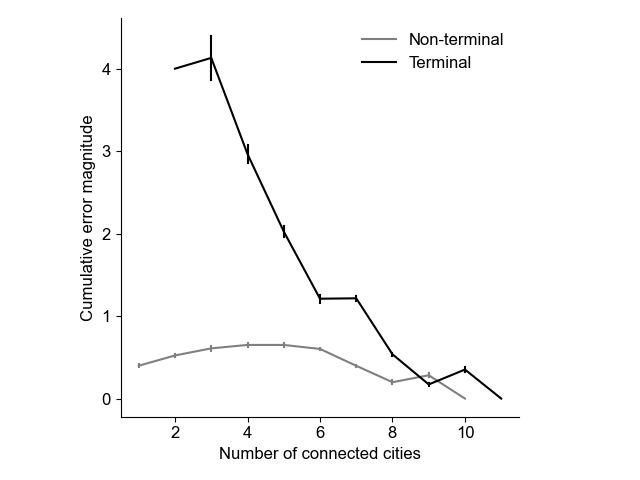

In [86]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)
# select error_sub when allMAS is 9 or 10
sns.lineplot(x='currNumCities', y='cumulative_error', 
             hue = "checkEnd", 
             data = error_sub, 
             errorbar = "se",
             err_style = "bars",
             palette = ['grey','k']
             )
axs.set(xlabel='Number of connected cities', ylabel='Cumulative error magnitude')
axs.legend(labels=['Non-terminal','Terminal'], frameon=False, loc='upper right')
axs.set_aspect(1/axs.get_data_ratio())
plt.tight_layout()
fig.savefig(out_dir+'cumulative_error_step_undo_condition.png', dpi=300, bbox_inches='tight')

#### error magnitude

In [82]:
error_sub = data_cond1_outcome.groupby(['subjects','currNumCities'])['severityOfErrors'].mean().reset_index()
# count_df = error_sub.groupby(['currNumCities','checkEnd'])['severityOfErrors'].count().reset_index()
# error_sub = error_sub.merge(count_df, on = ["currNumCities","checkEnd"], how = "left", suffixes = ("","_count"))
# error_sub = error_sub[error_sub['severityOfErrors_count'] > 30]

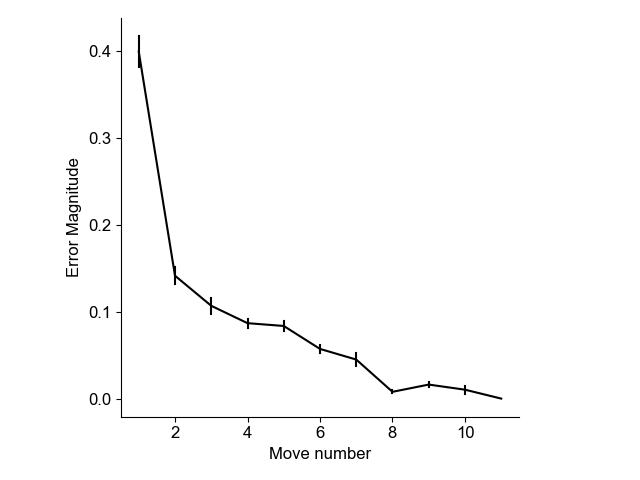

In [83]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)
# select error_sub when allMAS is 9 or 10
sns.lineplot(x='currNumCities', y='severityOfErrors', 
            #  hue = "checkEnd", 
             data = error_sub, 
             errorbar = "se",
             err_style = "bars",
             color = "k"
            #  palette = ['grey','k']
             )
axs.set(xlabel='Move number', ylabel='Error Magnitude')
# axs.set_ylim(0,0.5)
# axs.set_xticks([0,1,2,3,4,5,6,7,8])
# axs.legend(labels=['Non-terminal','Terminal'], frameon=False, loc='upper right')
# axs.set_title("With undo condition")
axs.set_aspect(1/axs.get_data_ratio())
plt.tight_layout()
fig.savefig(out_dir+'severityOfErrors_step_undo_condition.png', dpi=300, bbox_inches='tight')

#### error

In [16]:
error_sub = data_cond1_outcome.groupby(['subjects','currNumCities'])['error'].mean().reset_index()

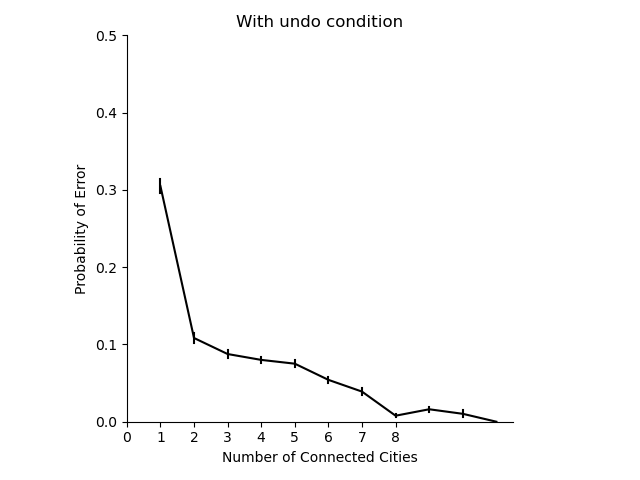

In [17]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)
# select error_sub when allMAS is 9 or 10
sns.lineplot(x='currNumCities', y='error', 
            #  hue = "allMAS", 
             color = "k",
             data = error_sub, # .loc[(error_sub.allMAS==8)|(error_sub.allMAS==9),:]
             errorbar = "se",
             err_style = "bars",
            #  palette = ['red','blue']
             )
axs.set(xlabel='Number of Connected Cities', ylabel='Probability of Error')
axs.set_ylim(0,0.5)
axs.set_xticks([0,1,2,3,4,5,6,7,8])
# axs.legend(title = "Puzzle MAS", frameon=False)
axs.set_title("With undo condition")
axs.set_aspect(1/axs.get_data_ratio())
plt.tight_layout()
fig.savefig(out_dir+'error_step_undo_condition.png', dpi=300, bbox_inches='tight')

##### statistics

In [ ]:
%%R 
model_error = lme4::glmer(error ~  1 + currNumCities + (1 |subjects),
                                  data = data_cond1_outcome, family = "binomial")
save(model_error, data_cond1_outcome, file=file.path(out_dir2, file=paste("model_error_step_undo_condition.RData", sep="")))
summary(model_error)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: error ~ 1 + prevNumCities + (1 | subjects)
   Data: data_cond1_outcome

     AIC      BIC   logLik deviance df.resid 
 27606.0  27632.9 -13800.0  27600.0    57530 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.0524 -0.3217 -0.2063 -0.1301 16.1670 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 0.08051  0.2838  
Number of obs: 57533, groups:  subjects, 100

Fixed effects:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -1.196736   0.037219  -32.15   <2e-16 ***
prevNumCities -0.459808   0.008891  -51.72   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
prevNumCits -0.462


## Puzzle MAS

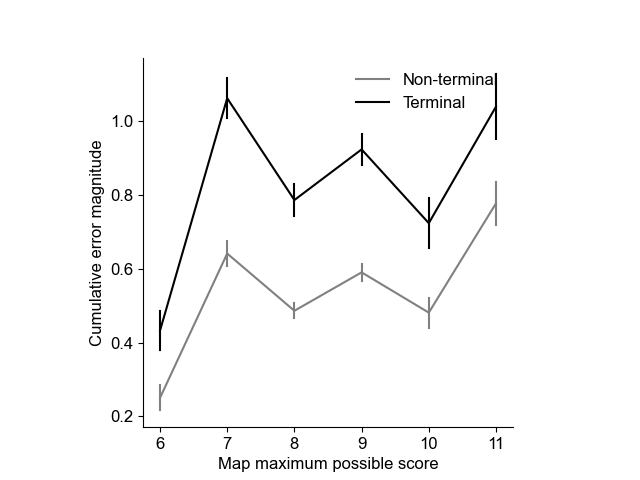

In [102]:
error_sub = data_cond1_outcome.groupby(['subjects','allMAS',"checkEnd"])['cumulative_error'].mean().reset_index()
error_sub.groupby(['allMAS',"checkEnd"])['cumulative_error'].count()
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='allMAS', y='cumulative_error', 
             data = error_sub,#[error_sub.checkEnd==1],
             hue = 'checkEnd',
             palette = ['grey','k'],
            #  color = 'k',
             err_style = "bars",
             errorbar = "se")
# axs.set_ylim(0,0.7)
axs.legend(labels=['Non-terminal','Terminal'], frameon=False, loc='upper right')
# axs.get_legend().remove()
axs.set(xlabel='Map maximum possible score', ylabel='Cumulative error magnitude')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'error_mas.png', dpi=300, bbox_inches='tight')
plt.show()

## remaining budget

In [89]:
error_sub = data_cond1_outcome.groupby(['subjects','leftover_bin',"checkEnd"])['cumulative_error'].mean().reset_index()
count_df = error_sub.groupby(['leftover_bin', 'checkEnd'])['cumulative_error'].count()
# error_sub = error_sub.merge(count_df, on = ["leftover_bin","checkEnd"], how = "left", suffixes = ("","_count"))
# error_sub = error_sub[error_sub['cumulative_error_count'] > 30]

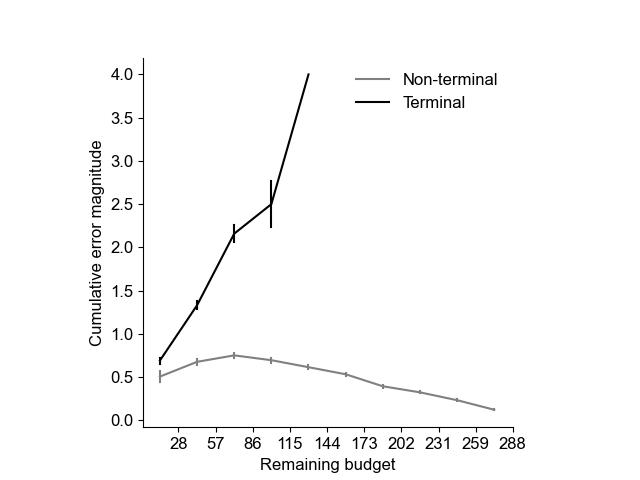

In [91]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='leftover_bin', y='cumulative_error', 
             data = error_sub,
             hue = "checkEnd",
            #  color = 'k',
             palette = ['grey','k'],
             err_style = "bars",
             errorbar = "se")
axs.set_xticks(np.arange(0.5, 10.5, 1))
axs.set_xticklabels(cutoff_budget[1:].astype(int))
axs.legend(labels=['Non-terminal','Terminal'], frameon=False, loc='upper right')
# axs.set_ylim(0,0.7)
axs.set(xlabel='Remaining budget', ylabel='Cumulative error magnitude')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'error_leftover.png', dpi=300, bbox_inches='tight')
plt.show()

In [152]:
spearmanr(data_cond1_outcome.loc[data_cond1_outcome.checkEnd==1,'leftover'], data_cond1_outcome.loc[data_cond1_outcome.checkEnd==1,'currNumCities'])

SpearmanrResult(correlation=-0.1774339897378646, pvalue=1.7192765690344817e-46)

## Budget change

In [43]:
error_sub = data_cond1_outcome.groupby(['subjects','budget_change_bin', 'N_more'])['severityOfErrors'].mean().reset_index()
count_df = error_sub.groupby(['budget_change_bin', 'N_more'])['severityOfErrors'].count()
# error_sub = error_sub.merge(count_df, on = ["budget_change_bin","checkEnd"], how = "left", suffixes = ("","_count"))
# error_sub = error_sub[error_sub['severityOfErrors_count'] > 30]

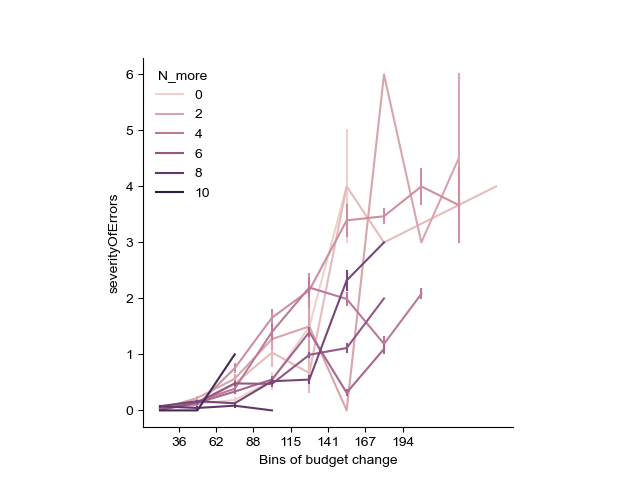

In [44]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='budget_change_bin', y='severityOfErrors', 
             hue = "N_more",
             data = error_sub,
            #  palette = ['grey','k'],
            #  color = 'k',
             err_style = "bars",
             errorbar = "se")
axs.set_xticks(np.arange(0.5, 7.5, 1))
axs.set_xticklabels(cutoff_budgetchange[1:8].astype(int))
# axs.legend(labels=['Non-terminal','Terminal'], frameon=False, loc='lower right')
#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
# axs.set_ylim(0,0.7)
axs.set(xlabel='Bins of budget change', ylabel='severityOfErrors')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'error_budgetchange_terminal.png', dpi=300, bbox_inches='tight')
plt.show()

## Within reach change

In [114]:
# plot undo across leftover_bin
undo_error_sub = data_cond1_outcome.groupby(['subjects','within_reach_change_bin', "checkEnd"])['severityOfErrors'].mean().reset_index()
count_df = undo_error_sub.groupby(['within_reach_change_bin', 'checkEnd'])['severityOfErrors'].count()
undo_error_sub = undo_error_sub.merge(count_df, on = ["within_reach_change_bin","checkEnd"], how = "left", suffixes = ("","_count"))
undo_error_sub = undo_error_sub[undo_error_sub['severityOfErrors_count'] > 30]

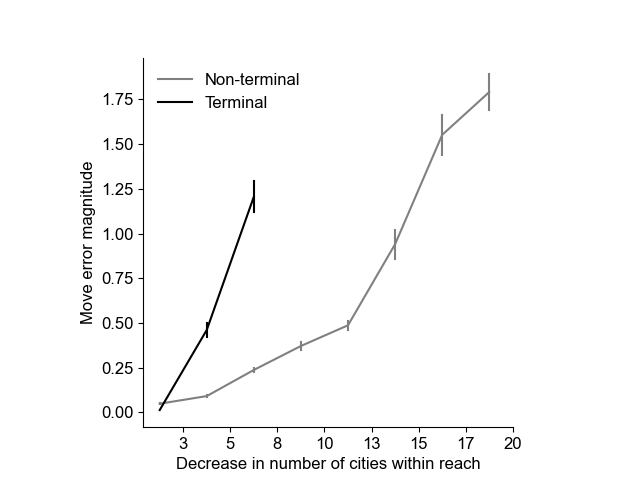

In [117]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot
sns.lineplot(x='within_reach_change_bin', y='severityOfErrors', 
             data = undo_error_sub,
             hue = "checkEnd",
                palette = ['grey','k'],
            #  color = 'k',
             err_style = "bars",
             errorbar = "se")
axs.set_xticks(np.arange(0.5, 8.5, 1))
axs.set_xticklabels(cutoff_withinreachchange[1:9].astype(int))
axs.legend(labels=['Non-terminal','Terminal'], frameon=False, loc='upper left')
axs.set(xlabel='Decrease in number of cities within reach', ylabel='Move error magnitude')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'error_withinreachchange_terminal.png', dpi=300, bbox_inches='tight')

In [60]:
spearmanr(data_cond1_outcome.loc[data_cond1_outcome.checkEnd==0,'within_reach_change'], data_cond1_outcome.loc[data_cond1_outcome.checkEnd==0,'budget_change'])

SpearmanrResult(correlation=0.5227938426313945, pvalue=0.0)

# Uncertainty (First-move RT)

In [33]:
# for RT1 and RT_branching, use only the very first undo
def uncertainty_df_process(df, condition, firstUndo):
    index = df.query(condition).index
    df_beforeUndo = df.loc[index-1,:]
    index_end_undo = df_beforeUndo.index[(df_beforeUndo.checkEnd == 1)] 
    state_undo_1undo = df_beforeUndo.loc[index_end_undo, ['subjects','puzzleID',"cumulative_error", 'currNumCities', "scaled_N_more_bin"]]

    state_undo_1undo = state_undo_1undo.merge(puzzleID_order_data.loc[puzzleID_order_data.condition==0, ["subjects","puzzleID", "RT1"]], on=["subjects","puzzleID"], how = "left")
    state_undo_1undo = state_undo_1undo.rename(columns = {"RT1":"RT1_basic"})
    state_undo_1undo = state_undo_1undo.merge(single_condition_data[["subjects","puzzleID", "RT1", "RT_branching"]], on=["subjects","puzzleID"], how = "left")
    state_undo_1undo["RT"] = list(df.loc[index_end_undo+1,'RT'])
    state_undo_1undo["RT1_log"] = np.log(state_undo_1undo["RT1"]+1)
    state_undo_1undo["RT1_basic_log"] = np.log(state_undo_1undo["RT1_basic"]+1)
    state_undo_1undo['firstUndo'] = firstUndo
    state_undo_1undo['error'] = state_undo_1undo['cumulative_error'] > 0
    return state_undo_1undo

state_undo_1undo = uncertainty_df_process(data_subset_before1undo, f"(firstUndo ==1)", 1)
state_notundo_1undo = uncertainty_df_process(data_subset_before1undo, f"(submit ==1)", 0)
state_df_1undo = pd.concat([state_undo_1undo,state_notundo_1undo])
state_df_1undo = state_df_1undo.reset_index(drop=True)

temp1, cutoff = pd.cut(state_df_1undo['RT1_log'], bins=5, labels=range(1,6),retbins=True)
state_df_1undo['rt1_bin'] = temp1.astype(int)

##### undo 

In [70]:
firstUndo_sub = state_df_1undo.groupby(['subjects','rt1_bin'])['firstUndo'].mean().reset_index()
firstUndo_sub.groupby(['rt1_bin'])['firstUndo'].count()

rt1_bin
1    98
2    99
3    74
4    22
5     4
Name: firstUndo, dtype: int64

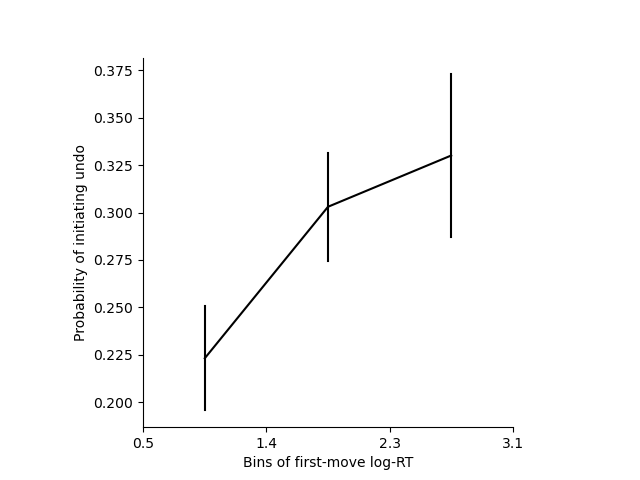

In [73]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='rt1_bin', y='firstUndo', 
             data = firstUndo_sub[firstUndo_sub.rt1_bin<=3],
             color = "k",
            #  hue = "error",
               #  palette = ['red','blue'],
             err_style = "bars",
             errorbar = "se")
#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
# use cutoff to set x ticklabels
#axs.set_xticks(np.arange(0.5, 7.5, 1))
# only use 1 decimal place
cutoff_round = [round(i,1) for i in cutoff]
axs.set_xticks(np.arange(0.5, 4.5, 1))
axs.set_xticklabels(cutoff_round[:-2])
# hide legend
# axs.get_legend().remove()
# axs.set_ylim([0,0.2])
# axs.set_yticks(np.arange(0, 0.25, 0.05))
axs.set(xlabel='Bins of first-move log-RT', ylabel='Probability of initiating undo')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'undo_first_rt.png', dpi=300, bbox_inches='tight')
plt.show()

##### error 

In [74]:
error_sub = state_df_1undo.groupby(['subjects','rt1_bin'])['cumulative_error'].mean().reset_index()
error_sub.groupby(['rt1_bin'])['cumulative_error'].count()

rt1_bin
1    98
2    99
3    74
4    22
5     4
Name: cumulative_error, dtype: int64

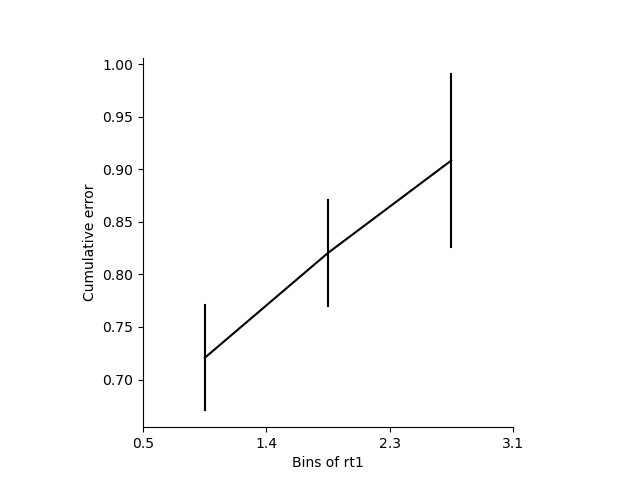

In [75]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='rt1_bin', y='cumulative_error', 
             data = error_sub[error_sub.rt1_bin<=3],
             color = 'k',
             err_style = "bars",
             errorbar = "se")
axs.set_xticks(np.arange(0.5, 4.5, 1))
axs.set_xticklabels(cutoff_round[:-2])
#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
# axs.set_ylim(0,0.7)
axs.set(xlabel='Bins of rt1', ylabel='Cumulative error')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'error_rt.png', dpi=300, bbox_inches='tight')
plt.show()

In [163]:
%%R -i state_df_1undo,out_dir2
state_df_1undo$subjects <- as.factor(state_df_1undo[,"subjects"])

model_undo = lme4::glmer(firstUndo ~  1 + RT1_log + (1 |subjects),
                                  data = state_df_1undo, family = binomial(link="logit"))

# save(model_undo, state_df_1undo, file=file.path(out_dir2, file=paste("model_undo_rt1.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: firstUndo ~ 1 + RT1_log + (1 | subjects)
   Data: state_df_1undo

     AIC      BIC   logLik deviance df.resid 
  6469.0   6489.3  -3231.5   6463.0     6401 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.3839 -0.6473 -0.2443  0.7099  6.6154 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 3.964    1.991   
Number of obs: 6404, groups:  subjects, 100

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.35180    0.23780  -9.890  < 2e-16 ***
RT1_log      0.49637    0.06736   7.369 1.72e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
        (Intr)
RT1_log -0.476


In [162]:
%%R -i state_df_1undo,out_dir2
state_df_1undo$subjects <- as.factor(state_df_1undo[,"subjects"])

model_undo = lme4::glmer(firstUndo ~  1 + RT1_basic_log + (1 |subjects),
                                  data = state_df_1undo, family = binomial(link="logit"))

# save(model_undo, state_df_1undo, file=file.path(out_dir2, file=paste("model_undo_rt1.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: firstUndo ~ 1 + RT1_basic_log + (1 | subjects)
   Data: state_df_1undo

     AIC      BIC   logLik deviance df.resid 
  6507.3   6527.6  -3250.7   6501.3     6401 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.1053 -0.6599 -0.2532  0.7362  5.9319 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 3.979    1.995   
Number of obs: 6404, groups:  subjects, 100

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -1.96611    0.23550  -8.348  < 2e-16 ***
RT1_basic_log  0.25432    0.06204   4.100 4.14e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
RT1_basc_lg -0.457


#### correlation with undoRT/submitRT

In [149]:
print(spearmanr(state_undo_1undo.groupby(['subjects'])['RT1'].mean() , state_undo_1undo.groupby(['subjects'])['undoRT'].mean()))

SpearmanrResult(correlation=0.39315581654348486, pvalue=0.00021603234339970947)


In [150]:
print(spearmanr(state_undo_1undo.groupby(['subjects'])['RT1'].mean() , state_undo_1undo.groupby(['subjects'])['RTsubmit'].mean()))

SpearmanrResult(correlation=0.3579021970233877, pvalue=0.0008301893408130178)


In [151]:
print(spearmanr(state_notundo_1undo.groupby(['subjects'])['RT1'].mean() , state_notundo_1undo.groupby(['subjects'])['RTsubmit'].mean()))

SpearmanrResult(correlation=0.5707948996201845, pvalue=1.2638417618044503e-09)


# RT

In [68]:
def organize_data(df, cond, type_):
    index_singleUndo = df.index[cond]
    df1 = df.loc[index_singleUndo, ['subjects', 'puzzleID', 'allMAS','RT', 'undo']]
    df1["N_more"] = df.loc[index_singleUndo-1, 'N_more'].values
    df1["currNumCities"] = df.loc[index_singleUndo-1, 'currNumCities'].values
    df1["severityOfErrors"] = df.loc[index_singleUndo-1, 'severityOfErrors'].values
    df1["cumulative_error"] = df.loc[index_singleUndo-1, 'cumulative_error'].values
    df1["scaled_N_more_bin"] = df.loc[index_singleUndo-1, 'scaled_N_more_bin'].values
    df1['type'] = type_
    return df1

df1 = organize_data(sc_data_choice_level, (sc_data_choice_level['firstUndo'] == 1) &(sc_data_choice_level['lastUndo'] == 1), "singleUndo")
df2 = organize_data(sc_data_choice_level, (sc_data_choice_level['firstUndo'] == 1) &(sc_data_choice_level['lastUndo'] != 1), "seqUndo")
df3 = organize_data(sc_data_choice_level, (sc_data_choice_level['undo'] == 0) & (sc_data_choice_level['RT'] != -1) & (sc_data_choice_level['submit'] == 0), "move")

df_all = pd.concat([df1, df2, df3])

### all states

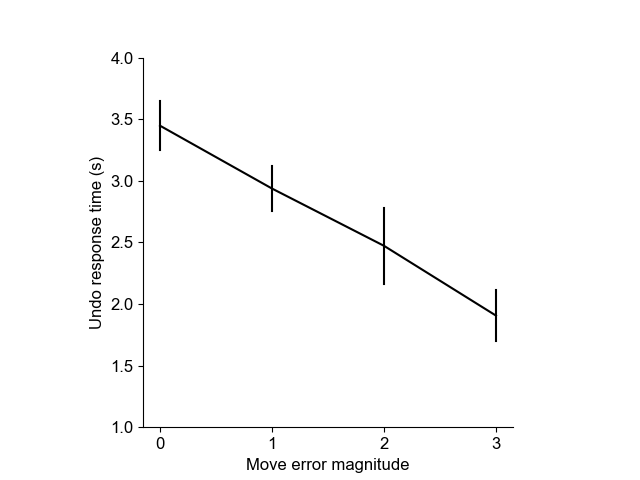

In [76]:
df = df_all[df_all.undo==1].groupby(['subjects','severityOfErrors'])['RT'].mean().reset_index()
count_df = df.groupby(['severityOfErrors'])['RT'].count().reset_index()
df = df.merge(count_df, on = ['severityOfErrors'], how = "left", suffixes = ("","_count"))
df = df[df['RT_count'] > 10]
df['RT'] = df['RT']/1000

%matplotlib widget
fig, axs = plt.subplots(1, 1)
sns.lineplot(x='severityOfErrors', y='RT', 
             data = df,
             err_style = "bars",
             errorbar = "se",
             color = 'k')
# x axis label
axs.set_xticks([0,1,2,3])
axs.set_yticks(np.linspace(1, 4, 7))
axs.set(xlabel='Move error magnitude', ylabel='Undo response time (s)')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'RT_severityOfError_allstates.png', dpi=300, bbox_inches='tight')

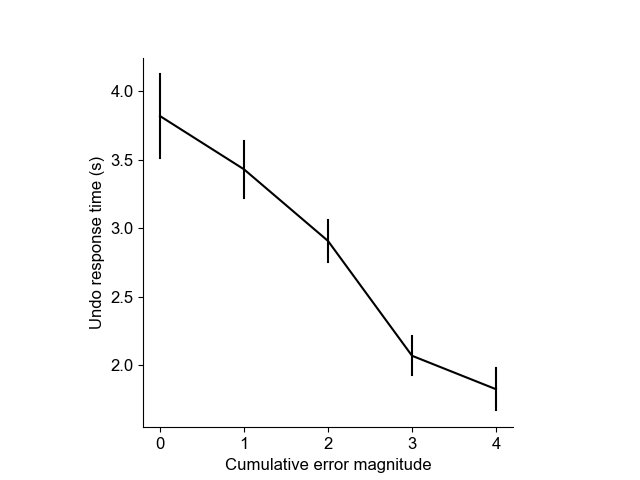

In [77]:
df = df_all[df_all.undo==1].groupby(['subjects','cumulative_error'])['RT'].mean().reset_index()
count_df = df.groupby(['cumulative_error'])['RT'].count().reset_index()
df = df.merge(count_df, on = ['cumulative_error'], how = "left", suffixes = ("","_count"))
df = df[df['RT_count'] > 10]
df['RT'] = df['RT']/1000

%matplotlib widget
fig, axs = plt.subplots(1, 1)
sns.lineplot(x='cumulative_error', y='RT', 
             data = df,
             err_style = "bars",
             errorbar = "se",
             color = 'k')
axs.set(xlabel='Cumulative error magnitude', ylabel='Undo response time (s)')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'RT_cumulative_error_allstates.png', dpi=300, bbox_inches='tight')

### from non-terminal state: undo/Move

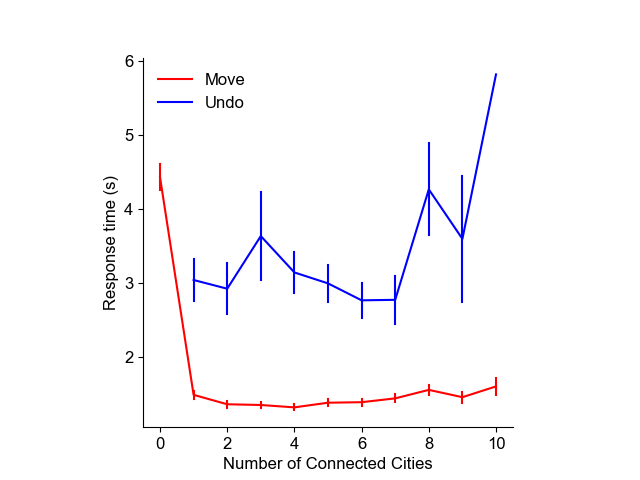

In [63]:
df = df_all[df_all.N_more != 0].groupby(["undo",'subjects','currNumCities'])['RT'].mean().reset_index() #
count_df = df.groupby(["undo",'currNumCities'])['RT'].count().reset_index()
df = df.merge(count_df, on = ["undo",'currNumCities'], how = "left", suffixes = ("","_count"))
# df = df[df['RT_count'] > 0]
df['RT'] = df['RT']/1000

%matplotlib widget
fig, axs = plt.subplots(1, 1)
sns.lineplot(x='currNumCities', y='RT', 
             data = df,
             err_style = "bars",
             errorbar = "se",
             hue = 'undo',
             palette = ['red','blue'])
# axs.set_xticks(np.arange(0.5, 10.5, 1))
# axs.set_xticklabels(cutoff_nmore[1:].round(2))
plt.legend(labels=['Move','Undo'], loc='upper left')
axs.set(xlabel='Number of Connected Cities', ylabel='Response time (s)')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'RT_currNumCities.png', dpi=300, bbox_inches='tight')

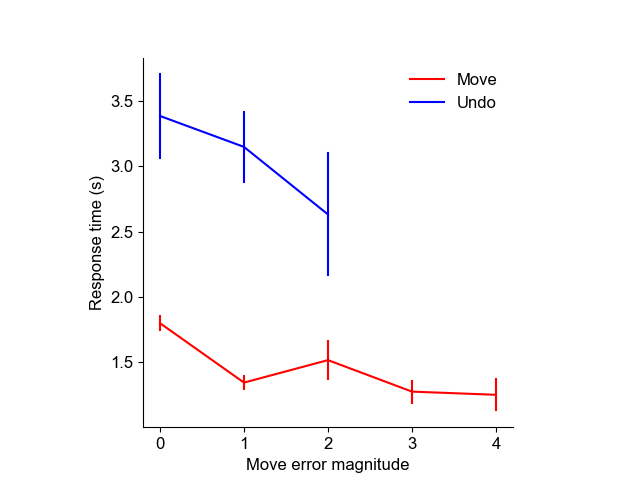

In [62]:
df = df_all[df_all.N_more != 0].groupby(["undo",'subjects','severityOfErrors'])['RT'].mean().reset_index()
count_df = df.groupby(["undo",'severityOfErrors'])['RT'].count().reset_index()
df = df.merge(count_df, on = ["undo",'severityOfErrors'], how = "left", suffixes = ("","_count"))
df = df[df['RT_count'] > 10]
df['RT'] = df['RT']/1000

%matplotlib widget
fig, axs = plt.subplots(1, 1)
sns.lineplot(x='severityOfErrors', y='RT', 
             data = df,
             err_style = "bars",
             errorbar = "se",
             hue = 'undo',
             palette = ['red','blue'])
# axs.set_xticks(np.arange(0.5, 10.5, 1))
# axs.set_xticklabels(cutoff_nmore[1:].round(2))
plt.legend(labels=['Move','Undo'], loc='upper right')
axs.set(xlabel='Move error magnitude', ylabel='Response time (s)')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'RT_severityOfError.png', dpi=300, bbox_inches='tight')

In [38]:
%%R -i df_all,out_dir2
df_all$subjects <- as.factor(df_all[,"subjects"])
df_all$puzzleID <- as.factor(df_all[,"puzzleID"])
df_all$undo <- as.factor(df_all[,"undo"])
df_all$RT <- df_all$RT/1000
df_all <- df_all[df_all$RT <= 20,]
df_all$RT_log <- log(df_all$RT)

write.csv(df_all, file = paste0(data_dir, "statsdata_rt_nonterminal.csv"), row.names = F)

### from terminal state: undo/submit

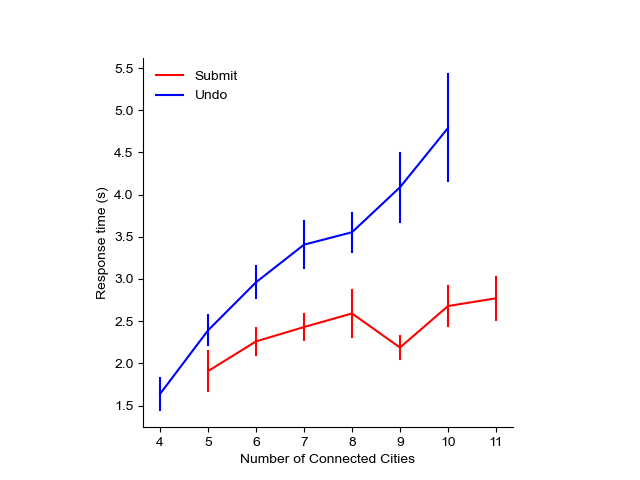

In [40]:
state_undo_1undo = uncertainty_df_process(sc_data_choice_level, f"(firstUndo ==1)", 1)
state_notundo_1undo = uncertainty_df_process(sc_data_choice_level, f"(submit ==1)", 0)
state_df_1undo = pd.concat([state_undo_1undo,state_notundo_1undo])
state_df_1undo = state_df_1undo.reset_index(drop=True)

plot_df = state_df_1undo.groupby(['subjects','firstUndo','currNumCities'])['RT'].mean().reset_index()
plot_df['RT'] = plot_df['RT']/1000
count_df = plot_df.groupby(['firstUndo','currNumCities'])['RT'].count()
plot_df = plot_df.merge(count_df, on = ['firstUndo','currNumCities'], how = "left", suffixes = ("","_count"))
plot_df = plot_df[plot_df['RT_count'] > 20]

# plot 
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot
sns.lineplot(x='currNumCities', y='RT', 
             data = plot_df,
             hue = 'firstUndo',
             palette = ['red','blue'],
             err_style = "bars",
             errorbar = "se")
# add manual legend
plt.legend(labels=['Submit','Undo'], loc='upper left')
axs.set(xlabel='Number of Connected Cities', ylabel='Response time (s)')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'undosubmit_RT_currNumCities.png', dpi=300, bbox_inches='tight')

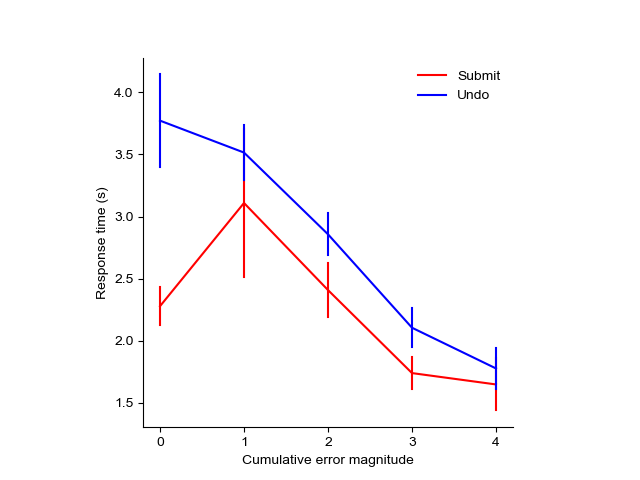

In [44]:
state_undo_1undo = uncertainty_df_process(sc_data_choice_level, f"(firstUndo ==1)", 1)
state_notundo_1undo = uncertainty_df_process(sc_data_choice_level, f"(submit ==1)", 0)
state_df_1undo = pd.concat([state_undo_1undo,state_notundo_1undo])
state_df_1undo = state_df_1undo.reset_index(drop=True)

plot_df = state_df_1undo.groupby(['subjects','firstUndo','cumulative_error'])['RT'].mean().reset_index()
plot_df['RT'] = plot_df['RT']/1000
count_df = plot_df.groupby(['firstUndo','cumulative_error'])['RT'].count()
plot_df = plot_df.merge(count_df, on = ['firstUndo','cumulative_error'], how = "left", suffixes = ("","_count"))
plot_df = plot_df[plot_df['RT_count'] > 10]

# plot 
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot
sns.lineplot(x='cumulative_error', y='RT', 
             data = plot_df,
             hue = 'firstUndo',
             palette = ['red','blue'],
             err_style = "bars",
             errorbar = "se")
# add manual legend
plt.legend(labels=['Submit','Undo'], loc='upper right')
axs.set(xlabel='Cumulative error magnitude', ylabel='Response time (s)')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'undosubmit_RT_cumulative_error.png', dpi=300, bbox_inches='tight')

In [35]:
%%R -i state_df_1undo,out_dir2
state_df_1undo$subjects <- as.factor(state_df_1undo[,"subjects"])
state_df_1undo$puzzleID <- as.factor(state_df_1undo[,"puzzleID"])
state_df_1undo$firstUndo <- as.factor(state_df_1undo[,"firstUndo"])
levels(state_df_1undo$firstUndo) <- c("submit", "undo")
state_df_1undo$RT <- state_df_1undo$RT/1000
state_df_1undo <- state_df_1undo[state_df_1undo$RT <= 20,]
state_df_1undo$RT_log <- log(state_df_1undo$RT)

write.csv(state_df_1undo, file = paste0(data_dir, "statsdata_rt_terminal.csv"), row.names = F)

### sequential undo and single undo

In [83]:
def get_undoRT(index):
    RT = data_choice_level.loc[index,:]
    RT_sub = RT.groupby(['subjects'])['undoRT'].mean()/1000
    RT_sub_sem = sem(RT_sub)
    return [RT_sub,RT_sub_sem]

index_singleUndo = data_choice_level.index[(data_choice_level['firstUndo'] == 1)&(data_choice_level['lastUndo'] == 1)]
RT_singleUndo = get_undoRT(index_singleUndo)

index_firstUndo = data_choice_level.index[(data_choice_level['firstUndo'] == 1) &(data_choice_level['lastUndo'] != 1)]
RT_firstUndo = get_undoRT(index_firstUndo)

index_laterUndo = data_choice_level.index[(data_choice_level['firstUndo'] != 1) & (data_choice_level['undo'] == 1)]
RT_laterUndo = get_undoRT(index_laterUndo)

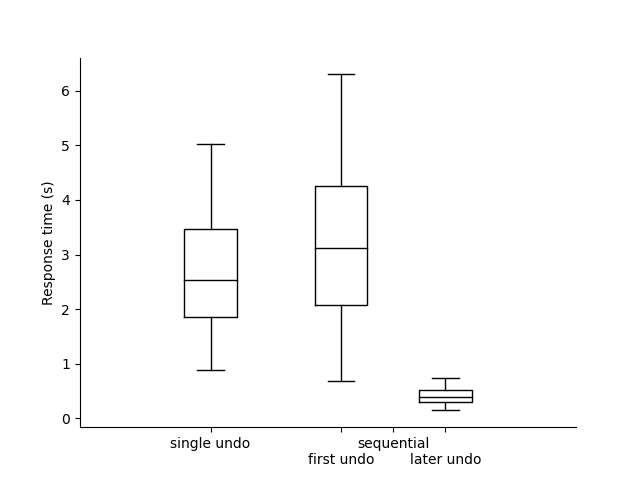

In [84]:
%matplotlib widget

fig, axs = plt.subplots(1, 1)

bx = axs.boxplot(
    [
        RT_singleUndo[0],
        RT_firstUndo[0],
        RT_laterUndo[0]
    ],
    positions =[0.5,1,1.4],
    widths = 0.2,
    showfliers=False,
    whis = 1,
   medianprops = dict(color = 'k'))  #

axs.set_xticks([0.5,1,1.2,1.4])
axs.set_xticklabels(labels = ['single undo','\nfirst undo','sequential','\nlater undo'])#,fontsize=18
axs.set_ylabel('Response time (s)') #,fontsize=18
plt.show()
fig.savefig(out_dir + 'undo_RT.png', dpi=600, bbox_inches='tight')

In [85]:
#--------------------------------------
# run 2-independent-sample t test
stat1, p1 = wilcoxon(np.log(1+RT_firstUndo[0]),np.log(1+RT_laterUndo[0]))
x1, x2 = 1,1.4
y, h, col = bx['caps'][3]._y[0] + 0.5, 0.1, 'k'
axs.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
text(p1)

#--------------------------------------
stat3, p3 = mannwhitneyu(np.log(1+RT_firstUndo[0]),np.log(1+RT_singleUndo[0]))
print(stat3, p3 )
x1, x2 = 0.5,1
y, h, col = bx['caps'][3]._y[0] + 0.5, 0.1, 'k'
axs.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
text(p3)
fig.savefig(out_dir + 'undo_RT.png', dpi=600, bbox_inches='tight')

4000.0 0.01593829273028334


# Undo completion

## Error before and after undo

In [26]:
mas_gain_df = pd.DataFrame(columns = ['subjects','puzzleID','cum_error_beginning','cum_error_end','error_beginning','error_rate_beginning','error_rate_end','mas_gain'])

for sub in range(100):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index_copy"]) # here the index is original index in data_choice_level    
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        
        cum_error_beginning_list = []
        error_beginning_list = []
        error_rate_beginning_list = []
    
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()        
        # all last undo
        lastUndo_idx = dat_sbj_pzi[(dat_sbj_pzi["lastUndo"]==1)].index 
        # exclude the case when there is no error from the beginning
        for x in lastUndo_idx:
            j = 0
            while dat_sbj_pzi.loc[x-j,"firstUndo"] == 0:
                j = j + 1
            # get cumulative error at undo beginning
            cum_error_beginning = dat_sbj_pzi.loc[x-j-1,"allMAS"] - dat_sbj_pzi.loc[x-j-1,"currMas"]
            cum_error_beginning_list.append(cum_error_beginning)
            error_beginning = dat_sbj_pzi.loc[x-j-1,"severityOfErrors"]
            error_beginning_list.append(error_beginning)
            error_rate_beginning = dat_sbj_pzi.loc[x-j-1,"error_rate"]
            error_rate_beginning_list.append(error_rate_beginning)

        # cumulative error at undo terminal
        df_undoTarget = dat_sbj_pzi.loc[lastUndo_idx,:]
        accu_severity_error = list(df_undoTarget['allMAS'] - df_undoTarget['currMas'])
        error_rate_end = list(df_undoTarget['error_rate'])
        # use each value in cum_error_beginning_list to subtract accu_severity_error
        mas_gain = []
        cum_error_end_list = []
        error_rate_end_list = []
        for i in range(len(cum_error_beginning_list)):
            mas_gain.append(cum_error_beginning_list[i] - accu_severity_error[i])
            cum_error_end_list.append(accu_severity_error[i])
            error_rate_end_list.append(error_rate_end[i])
        
        
        # if category is not empty, add it to an empty dataframe
        if len(mas_gain) > 0:
            mas_gain_df = pd.concat([mas_gain_df,pd.DataFrame({'subjects':sub,'puzzleID':pzi,
                                                               'cum_error_beginning':cum_error_beginning_list, 'cum_error_end':cum_error_end_list,
                                                               'error_beginning':error_beginning_list, 
                                                               'error_rate_beginning':error_rate_beginning_list,
                                                               'error_rate_end':error_rate_end_list,
                                                               'mas_gain':mas_gain})])


### Barplot

In [28]:
# scatter plot of cum_error_beginning and cum_error_end in mas_gain_df  
error_df_sub = mas_gain_df.groupby(['subjects'])[['cum_error_beginning','cum_error_end']].mean().reset_index()

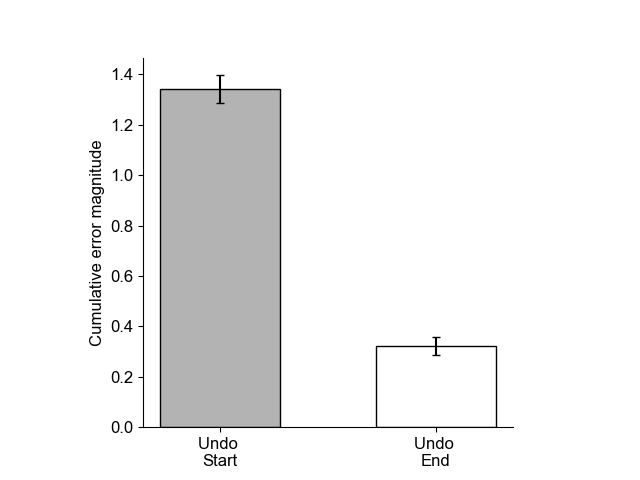

In [31]:
# This uses all undo
# plot in a scatter plot
%matplotlib widget
fig, axs = plt.subplots(1, 1)

positions = [1, 1.9]

mean_values = [error_df_sub['cum_error_beginning'].mean(), error_df_sub['cum_error_end'].mean()]
bars = axs.bar(positions,
               mean_values,
               width=0.5,
               color=[(.7, .7, .7), 'w', (.7, .7, .7), 'w'],
               edgecolor='k')

# add standard error
errs = axs.errorbar(positions,
                    mean_values,
                    yerr=[error_df_sub['cum_error_beginning'].sem(), error_df_sub['cum_error_end'].sem()],
                    fmt='none',  # No connecting line
                    capsize=3,  # Cap size for error bar
                    ecolor='k')  # Error bar color

axs.set_ylabel('Cumulative error magnitude')
axs.set_xticks([1,1.9])
axs.set_xticklabels(labels = ['Undo \nStart',
                              'Undo \nEnd'])#,fontsize=18

# set ratio to be 1:1
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir + 'error_before_after_undo.png', dpi=300, bbox_inches='tight')

In [32]:
cum_error_before = mas_gain_df.groupby(['subjects'])['cum_error_beginning'].mean()
cum_error_after = mas_gain_df.groupby(['subjects'])['cum_error_end'].mean()

y_offset = 0.1
h = 0.05
stat3, p3 = wilcoxon(cum_error_before, cum_error_after, alternative = 'greater')
print(stat3, p3 )
x1, x2 = positions
y, col = max(mean_values) + y_offset, 'k'
axs.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
text(p3)
fig.savefig(out_dir + 'error_before_after_undo.png', dpi=600, bbox_inches='tight')

3916.0 1.8266971276429214e-16


### Error rate

In [ ]:
# scatter plot of cum_error_beginning and cum_error_end in mas_gain_df  
error_df_sub = mas_gain_df.groupby(['subjects'])['error_rate_beginning','error_rate_end'].mean().reset_index()
error_df_sub

/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_36892/3460544585.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  error_df_sub = mas_gain_df.groupby(['subjects'])['error_rate_beginning','error_rate_end'].mean().reset_index()


,subjects,error_rate_beginning,error_rate_end
0,0,0.171176,0.015152
1,1,0.252847,0.113872
2,2,0.299482,0.055556
3,3,0.547619,0.000000
4,4,0.266478,0.084921
...,...,...,...
85,94,0.800000,0.000000
86,95,0.144901,0.091991
87,96,0.120201,0.011792
88,97,0.436508,0.166667


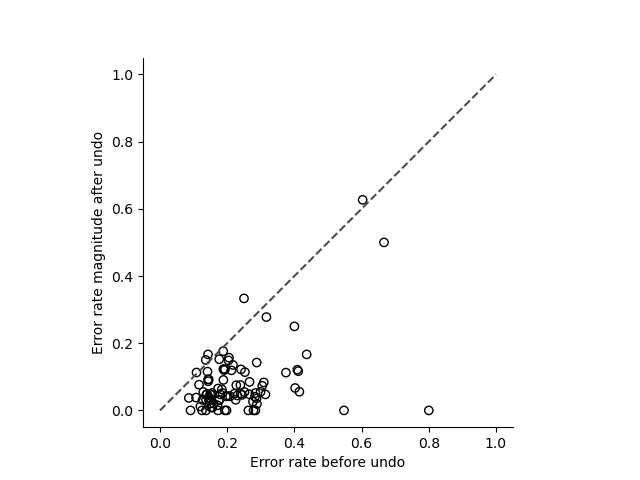

In [ ]:
%matplotlib widget
fig1, ax1 = plt.subplots()

sns.scatterplot(x='error_rate_beginning', y='error_rate_end', 
                            # use white fill
                edgecolor="black",
                facecolor="None",
                linewidth=1,
                data=error_df_sub) 
# add diagonal line
ax1.plot([0, 1], [0, 1], ls="--", c=".3")
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
# ax1.set_xticks(np.arange(0, 1.5, 1))
# ax1.set_yticks(np.arange(0, 1.5, 1))
ax1.set_xlabel("Error rate before undo")
ax1.set_ylabel("Error rate magnitude after undo")
ax1.set_aspect(1/ax1.get_data_ratio())
fig1.savefig(out_dir+'errorrate_before_after_undo.png', dpi=300, bbox_inches='tight')
plt.show()

## Proportion of different undo result

In [40]:
accu_error_3 = pd.DataFrame(columns = ['subjects','puzzleID','terminal_beginning','cum_error_beginning','error_beginning','error_rate_beginning','category'])

for sub in range(100):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index_copy"]) # here the index is original index in data_choice_level    
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        
        cum_error_beginning_list = []
        error_beginning_list = []
        error_rate_beginning_list = []
        terminal_beginning_list = []
    
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()        

        # last undo index when it is not the start city
        lastUndo_idx_nostart = dat_sbj_pzi[(dat_sbj_pzi["lastUndo"]==1)&(dat_sbj_pzi["choice"]!=0)].index 
        # exclude the case when there is no error from the beginning
        for x in lastUndo_idx_nostart:
            j = 0
            while dat_sbj_pzi.loc[x-j,"firstUndo"] == 0:
                j = j + 1

            if dat_sbj_pzi.loc[x-j-1,"allMAS"] - dat_sbj_pzi.loc[x-j-1,"currMas"] == 0: # the state before first undo
                lastUndo_idx_nostart = lastUndo_idx_nostart.drop(x)
            else: 
                # get cumulative error at undo beginning
                cum_error_beginning = dat_sbj_pzi.loc[x-j-1,"allMAS"] - dat_sbj_pzi.loc[x-j-1,"currMas"]
                cum_error_beginning_list.append(cum_error_beginning)
                error_beginning = dat_sbj_pzi.loc[x-j-1,"severityOfErrors"]
                error_beginning_list.append(error_beginning)
                error_rate_beginning = dat_sbj_pzi.loc[x-j-1,"error_rate"]
                error_rate_beginning_list.append(error_rate_beginning)
                terminal_beginning = dat_sbj_pzi.loc[x-j-1,"checkEnd"]
                terminal_beginning_list.append(terminal_beginning)

        # cumulative error at undo terminal
        df_undoTarget = dat_sbj_pzi.loc[lastUndo_idx_nostart,:]
        accu_severity_error = list(df_undoTarget['allMAS'] - df_undoTarget['currMas'])

        # cumulative error at the state before undo terminal
        df_undoTarget_before = dat_sbj_pzi.loc[lastUndo_idx_nostart-1,:]
        accu_severity_error_before = list(df_undoTarget_before['allMAS'] - df_undoTarget_before['currMas'])
        
        sequential_single = (dat_sbj_pzi.loc[lastUndo_idx_nostart,"firstUndo"] == 1)&(dat_sbj_pzi.loc[lastUndo_idx_nostart,"lastUndo"] == 1)
        category = [np.nan]*len(accu_severity_error) # the number of undo terminal
        
        for i in range(len(accu_severity_error)): 
            if accu_severity_error_before[i]==0: # undo too much
                category[i] = 0
            elif (accu_severity_error[i]==0)&(accu_severity_error_before[i]>0): # undo exactly the right amount
                category[i] = 1
            elif accu_severity_error[i] > 0: # undo too little
                category[i] = 2
        
        # if category is not empty, add it to an empty dataframe
        if len(category) > 0:
            accu_error_3 = pd.concat([accu_error_3,pd.DataFrame({'subjects':sub,'puzzleID':pzi,
                                                                 'cum_error_beginning':cum_error_beginning_list,'error_beginning':error_beginning_list,
                                                                    'error_rate_beginning':error_rate_beginning_list, 
                                                                    'sequential_single':sequential_single,
                                                                    'terminal_beginning':terminal_beginning_list,
                                                                 'category':category})])

accu_error_3["terminal"] = "notstart"

In [41]:
# create empty dataframe
accu_error_2 = pd.DataFrame(columns = ['subjects','puzzleID', 'terminal_beginning', 'cum_error_beginning','error_beginning','error_rate_beginning','category'])

for sub in range(100):
    dat_sbj  = sc_data_choice_level.loc[(sc_data_choice_level['subjects']==sub),:].sort_values(["puzzleID","index_copy"])
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        
        cum_error_beginning_list = []
        error_beginning_list = []
        error_rate_beginning_list = []
        terminal_beginning_list = []

        dat_sbj_pzi = dat_sbj.loc[(dat_sbj['puzzleID'] == pzi),:].reset_index()    

        # last undo index when it is not the start city
        # only select rows when (dat_sbj_pzi["lastUndo"]==1)&(dat_sbj_pzi["choice"]==0)
        lastUndo_idx_start = dat_sbj_pzi[(dat_sbj_pzi.lastUndo==1)&(dat_sbj_pzi.choice==0)].index
        # exclude the case when there is no error from the beginning
        for x in lastUndo_idx_start:
            j = 0
            while dat_sbj_pzi.loc[x-j,"firstUndo"] == 0:
                j = j + 1
            
            if dat_sbj_pzi.loc[x-j-1,"allMAS"] - dat_sbj_pzi.loc[x-j-1,"currMas"] == 0:
                lastUndo_idx_start = lastUndo_idx_start.drop(x)
            else: 
                # get cumulative error at undo beginning
                cum_error_beginning = dat_sbj_pzi.loc[x-j-1,"allMAS"] - dat_sbj_pzi.loc[x-j-1,"currMas"]
                cum_error_beginning_list.append(cum_error_beginning)
                error_beginning = dat_sbj_pzi.loc[x-j-1,"severityOfErrors"]
                error_beginning_list.append(error_beginning)
                error_rate_beginning = dat_sbj_pzi.loc[x-j-1,"error_rate"]
                error_rate_beginning_list.append(error_rate_beginning)
                terminal_beginning = dat_sbj_pzi.loc[x-j-1,"checkEnd"]
                terminal_beginning_list.append(terminal_beginning)
                
        # cumulative error at undo terminal
        df_undoTarget = dat_sbj_pzi.loc[lastUndo_idx_start,:]
        accu_severity_error = list(df_undoTarget['allMAS'] - df_undoTarget['currMas'])
        # cumulative error at the state before undo terminal
        df_undoTarget_before = dat_sbj_pzi.loc[lastUndo_idx_start-1,:]
        accu_severity_error_before = list(df_undoTarget_before['allMAS'] - df_undoTarget_before['currMas'])
        
        sequential_single = (dat_sbj_pzi.loc[lastUndo_idx_start,"firstUndo"] == 1)&(dat_sbj_pzi.loc[lastUndo_idx_start,"lastUndo"] == 1)
        category = [np.nan]*len(accu_severity_error)
        
        for i in range(len(accu_severity_error)): 
            if accu_severity_error_before[i]==0: # undo too much
                category[i] = 0
            elif (accu_severity_error[i]==0)&(accu_severity_error_before[i]>0): # undo exactly the right amount
                category[i] = 1

        # if category is not empty, add it to an empty dataframe
        if len(category) > 0:
            accu_error_2 = pd.concat([accu_error_2,pd.DataFrame({'subjects':sub,'puzzleID':pzi,
                                                                 'cum_error_beginning':cum_error_beginning_list,'error_beginning':error_beginning_list,
                                                                    'error_rate_beginning':error_rate_beginning_list,
                                                                    'sequential_single':sequential_single,
                                                                    'terminal_beginning':terminal_beginning_list,
                                                                 'category':category})])

accu_error_2["terminal"] = "start"

In [42]:
# combine accu_error_2 and accu_error_3 into one dataframe
accu_error = pd.concat([accu_error_2,accu_error_3])
# calcualte the proportion of each category plus terminal, grouped by subjects
accu_error_p = accu_error.groupby(['category','terminal','subjects']).size().unstack(fill_value=0).apply(lambda x: x/x.sum())
accu_error_p = accu_error_p.T
accu_error_p

category         0                   1                   2
terminal  notstart     start  notstart     start  notstart
subjects                                                  
0         0.222222  0.111111  0.555556  0.000000  0.111111
1         0.043478  0.000000  0.347826  0.173913  0.434783
2         0.033333  0.300000  0.066667  0.533333  0.066667
3         0.000000  0.500000  0.000000  0.500000  0.000000
4         0.000000  0.105263  0.105263  0.473684  0.315789
...            ...       ...       ...       ...       ...
94        0.000000  0.000000  0.000000  1.000000  0.000000
95        0.125000  0.083333  0.166667  0.333333  0.291667
96        0.142857  0.114286  0.257143  0.428571  0.057143
97        0.000000  0.000000  0.333333  0.333333  0.333333
99        0.227273  0.181818  0.045455  0.409091  0.136364

[90 rows x 5 columns]

In [254]:
accu_error = accu_error.merge(single_condition_data[["subjects",'puzzleID','RT1']], on= ["subjects",'puzzleID'], how = "left")

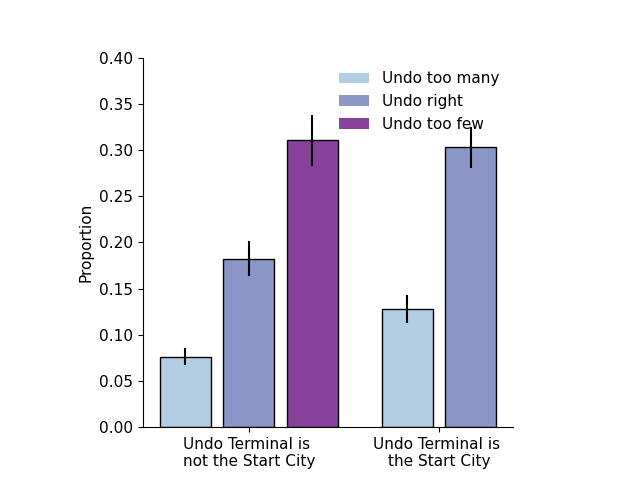

In [187]:
%matplotlib widget

fig, axs = plt.subplots(1, 1)
plt.bar(range(3), np.mean(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="notstart"],axis=0),
        color= ["#b3cde3", "#8c96c6", "#88419d"], 
        edgecolor = 'k', 
        yerr= np.std(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="notstart"],axis = 0)/np.sqrt(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="notstart"].shape[0]))
plt.bar([3.5,4.5], np.mean(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="start"],axis=0),
        edgecolor = 'k', 
        color= ["#b3cde3", "#8c96c6"],
        yerr= np.std(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="start"],axis = 0)/np.sqrt(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="start"].shape[0])
               )
#plt.legend(color = ["red", "blue", "green"],
#           labels = ['Undo too many','Undo right','Undo too few'])
legend_elements = [Patch(facecolor='#b3cde3', label='Undo too many'),    
                   Patch(facecolor='#8c96c6', label='Undo right'),    
                   Patch(facecolor='#88419d', label='Undo too few')]
# create the legend
plt.legend(handles=legend_elements)


plt.xticks([1,4], ['Undo Terminal is \nnot the Start City','Undo Terminal is \nthe Start City'])
plt.ylabel('Proportion')
# 
axs.set_ylim([0,0.4])
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'undo_completion type.png', dpi=300, bbox_inches='tight')

## what predicts the undo terminal

### sequential or single

<AxesSubplot:xlabel='terminal_beginning', ylabel='terminal_number'>

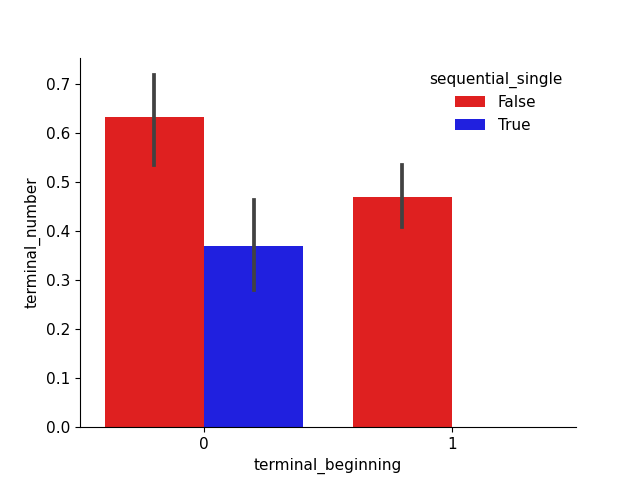

In [202]:
accu_error["terminal_number"] = (accu_error.terminal=="start").astype(int)

plot_df = accu_error.groupby(['sequential_single','terminal_beginning','subjects'])['terminal_number'].mean().reset_index()
# plot 
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot
sns.barplot(x='terminal_beginning', y='terminal_number', 
             data = plot_df,
             hue = 'sequential_single',
             palette = ['red','blue'])

### RT1

  rt1_bin  terminal_number
0       1               32
1       2               75
2       3               73
3       4               61
4       5               41


<AxesSubplot:xlabel='rt1_bin', ylabel='terminal_number'>

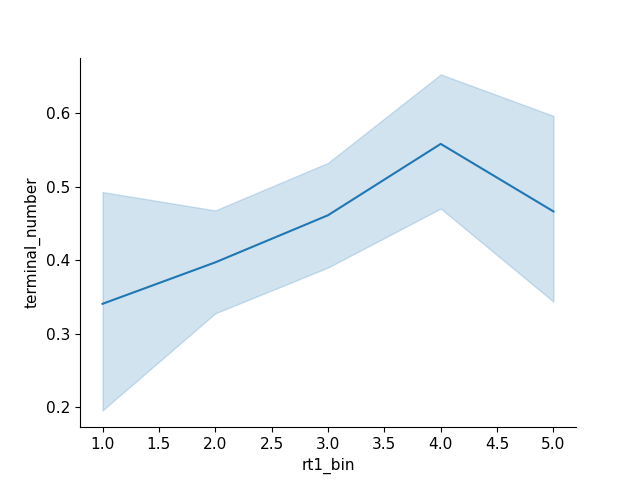

In [230]:
accu_error['RT1_log'] = np.log(1+accu_error.RT1)
temp1, cutoff = pd.cut(accu_error['RT1_log'], bins=[0,1,1.5,2,2.5,5], labels=range(1,6),retbins=True)
accu_error['rt1_bin'] = temp1

accu_error["terminal_number"] = (accu_error.terminal=="start").astype(int)

plot_df = accu_error.groupby(['rt1_bin','subjects'])['terminal_number'].mean().reset_index()
print(plot_df.groupby(['rt1_bin'])['terminal_number'].count().reset_index())
# plot 
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot
sns.lineplot(x='rt1_bin', y='terminal_number', 
             data = plot_df)

### cumulative error magnitude

In [43]:
accu_error['undo_right'] = (accu_error.category==1)
accu_error['undo_too_many'] = (accu_error.category==0)
accu_error['undo_too_few'] = (accu_error.category==2)

In [44]:
undo_right_sub = accu_error.groupby(['subjects','cum_error_beginning'])['undo_right'].mean().reset_index()
undo_right_sub.groupby(['cum_error_beginning'])['undo_right'].count()

cum_error_beginning
1    82
2    82
3    58
4    31
5     4
6     1
Name: undo_right, dtype: int64

In [45]:
accu_error

,subjects,puzzleID,terminal_beginning,cum_error_beginning,error_beginning,error_rate_beginning,category,sequential_single,terminal,undo_right,undo_too_many,undo_too_few
10,0,28,1,3,0,0.500000,0,False,start,False,True,False
10,1,15,1,3,1,0.500000,1,False,start,True,False,False
14,1,18,1,2,0,0.250000,1,False,start,True,False,False
10,1,30,0,1,0,0.166667,1,False,start,True,False,False
4,1,38,0,2,1,0.666667,1,False,start,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
17,99,17,1,1,0,0.142857,0,False,notstart,False,True,False
3,99,24,0,1,0,0.333333,2,True,notstart,False,False,True
25,99,29,1,1,0,0.125000,0,False,notstart,False,True,False
13,99,31,1,1,0,0.111111,0,False,notstart,False,True,False


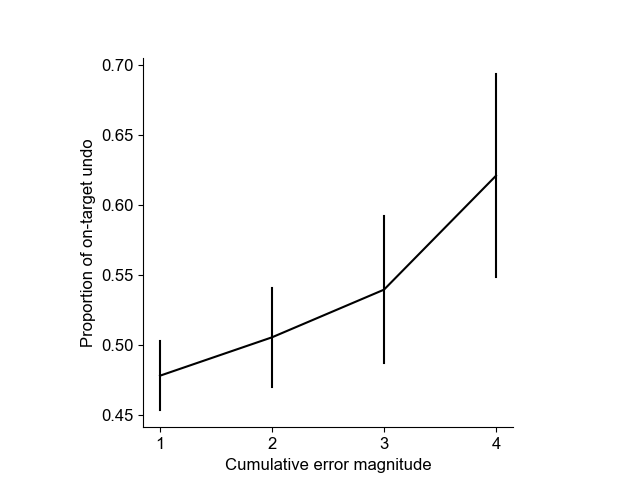

In [48]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

sns.lineplot(x='cum_error_beginning', y='undo_right',
                data = undo_right_sub[undo_right_sub.cum_error_beginning<=4],
                color = 'black', #'#8da0cb'
                err_style = "bars",
                errorbar = "se")

axs.set_xticks([1,2,3,4])
#axs.set_ylim(0,0.15)

axs.set(xlabel='Cumulative error magnitude', ylabel='Proportion of on-target undo')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'undo_right_cumulative_error.png', dpi=300, bbox_inches='tight')

In [256]:
%%R -i accu_error,out_dir2
accu_error$subjects <- as.factor(accu_error[,"subjects"])

model_undo_right = lme4::glmer(undo_right ~  1 + cum_error_beginning + (1 |subjects) ,
                                  data = accu_error, family = binomial(link="logit"))

save(model_undo_right, accu_error, file=file.path(out_dir2, file=paste("model_undo_right_cumulative_error.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo_right)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: undo_right ~ 1 + cum_error_beginning + (1 | subjects)
   Data: accu_error

     AIC      BIC   logLik deviance df.resid 
  2766.4   2783.2  -1380.2   2760.4     2041 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.6249 -0.9121 -0.5769  1.0031  2.0223 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 0.2796   0.5287  
Number of obs: 2044, groups:  subjects, 90

Fixed effects:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -0.53693    0.12360  -4.344 1.40e-05 ***
cum_error_beginning  0.27524    0.06059   4.543 5.56e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
cm_rrr_bgnn -0.765


### error magnitude before undo

In [49]:
undo_right_sub = accu_error.groupby(['subjects','error_beginning'])['undo_right'].mean().reset_index()
undo_right_sub.groupby(['error_beginning'])['undo_right'].count()

error_beginning
0    86
1    76
2    33
3    14
4     1
6     1
Name: undo_right, dtype: int64

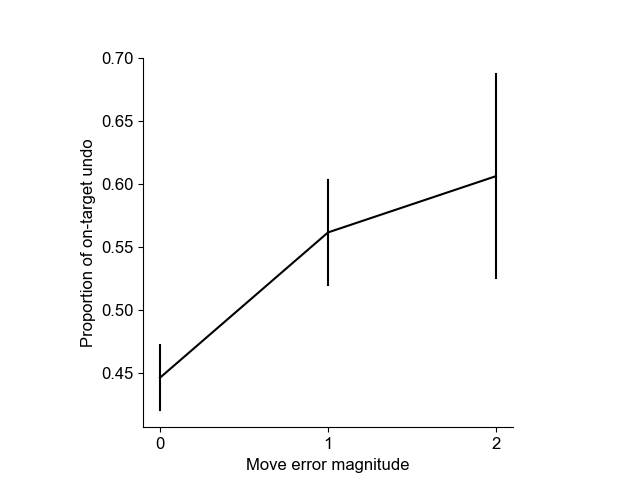

In [51]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

sns.lineplot(x='error_beginning', y='undo_right',
                data = undo_right_sub[undo_right_sub.error_beginning<=2],
                color = 'black', #'#8da0cb'
                err_style = "bars",
                errorbar = "se")

axs.set_xticks([0,1,2])
#axs.set_ylim(0,0.15)

axs.set(xlabel='Move error magnitude', ylabel='Proportion of on-target undo')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'undo_right_error.png', dpi=300, bbox_inches='tight')

In [257]:
%%R -i accu_error,out_dir2
accu_error$subjects <- as.factor(accu_error[,"subjects"])
accu_error$error_beginning <- scale(accu_error$error_beginning)
accu_error$cum_error_beginning <- scale(accu_error$cum_error_beginning)

model_undo_right = lme4::glmer(undo_right ~  1 + error_beginning + (1 |subjects) ,
                                  data = accu_error, 
                                  family = binomial(link="logit"))

save(model_undo_right, accu_error, file=file.path(out_dir2, file=paste("model_undo_right_error_and_cumulative.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo_right)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: undo_right ~ 1 + error_beginning + (1 | subjects)
   Data: accu_error

     AIC      BIC   logLik deviance df.resid 
  2763.7   2780.6  -1378.8   2757.7     2041 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9653 -0.9051 -0.5924  1.0037  1.6881 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 0.272    0.5215  
Number of obs: 2044, groups:  subjects, 90

Fixed effects:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -0.11554    0.07903  -1.462    0.144    
error_beginning  0.23512    0.04992   4.709 2.48e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
errr_bgnnng -0.014


### Error rate

In [ ]:
undo_right_sub = accu_error.groupby(['subjects','error_rate_beginning'])['undo_right'].mean().reset_index()
undo_right_sub.groupby(['error_rate_beginning'])['undo_right'].count()

error_rate_beginning
0.090909    28
0.100000    28
0.111111    66
0.125000    70
0.142857    60
0.166667    54
0.200000    24
0.222222    16
0.250000    69
0.285714    62
0.333333    48
0.375000     6
0.400000    29
0.428571    35
0.500000    57
0.571429     1
0.600000    20
0.666667    19
0.714286     1
0.750000     7
0.800000    14
0.833333     1
1.000000    22
1.250000     1
1.333333     7
1.500000     6
2.000000     1
3.000000     1
Name: undo_right, dtype: int64

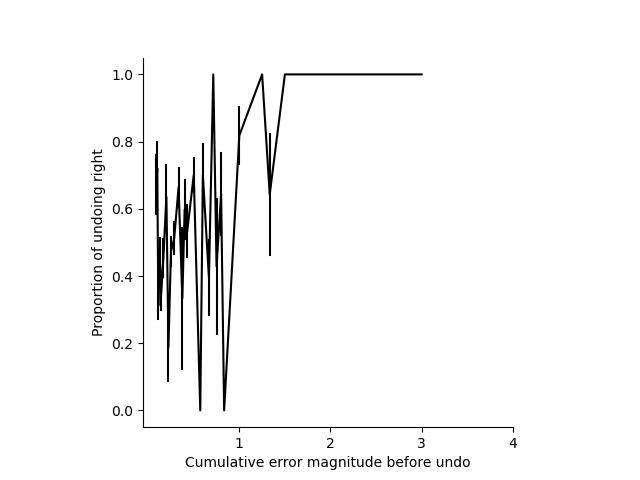

In [ ]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

sns.lineplot(x='error_rate_beginning', y='undo_right',
                data = undo_right_sub,
                color = 'black', #'#8da0cb'
                err_style = "bars",
                errorbar = "se")

axs.set_xticks([1,2,3,4])
#axs.set_ylim(0,0.15)

axs.set(xlabel='Cumulative error magnitude before undo', ylabel='Proportion of undoing right')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'undo_right_cumulative_errorrate.png', dpi=300, bbox_inches='tight')

## Correlations

## Metric 1: proportions

In [ ]:
score = puzzleID_order_data[puzzleID_order_data['condition']==0].groupby(['subjects'])['sumSeverityErrors'].mean()
undo_right_prop = accu_error.groupby(['subjects'])['undo_right'].mean()

# only keep subjects who have both scores
score = score[score.index.isin(undo_right_prop.index)]

spearmanr(score, undo_right_prop)

SpearmanrResult(correlation=-0.13312064506005297, pvalue=0.21100181575591548)

In [ ]:
score = puzzleID_order_data[puzzleID_order_data['condition']==0].groupby(['subjects'])['sumSeverityErrors'].mean()
undo_few_prop = accu_error.groupby(['subjects'])['undo_too_few'].mean()

# only keep subjects who have both scores
score = score[score.index.isin(undo_few_prop.index)]

spearmanr(score, undo_few_prop)

SpearmanrResult(correlation=0.1470036625195117, pvalue=0.16677864009093307)

In [ ]:
balanced_accuracy = balanced_accuracy[balanced_accuracy.index.isin(undo_right_prop.index)]
spearmanr(balanced_accuracy, undo_right_prop)

SpearmanrResult(correlation=-0.033595457200651664, pvalue=0.7532566675233603)

In [ ]:
balanced_accuracy = balanced_accuracy[balanced_accuracy.index.isin(undo_few_prop.index)]
spearmanr(balanced_accuracy, undo_few_prop)

SpearmanrResult(correlation=-0.06698676011526265, pvalue=0.5304532980708084)

## Metric 2: Error rate change

In [ ]:
error_df_sub = mas_gain_df.groupby(['subjects'])['error_rate_beginning','error_rate_end'].mean().reset_index()
error_rate_change = error_df_sub['error_rate_end'] - error_df_sub['error_rate_beginning']
score = puzzleID_order_data[puzzleID_order_data['condition']==0].groupby(['subjects'])['sumSeverityErrors'].mean()
score = score[score.index.isin(error_rate_change.index)]
spearmanr(error_rate_change, score)

/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_36892/3807902533.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  error_df_sub = mas_gain_df.groupby(['subjects'])['error_rate_beginning','error_rate_end'].mean().reset_index()


SpearmanrResult(correlation=-0.03115437580352458, pvalue=0.7706722334841731)

In [ ]:
error_df_sub = mas_gain_df.groupby(['subjects'])['error_rate_beginning','error_rate_end'].mean().reset_index()
error_rate_change = error_df_sub['error_rate_end'] - error_df_sub['error_rate_beginning']
balanced_accuracy = (undo_error_avg + TNR)/2
balanced_accuracy = balanced_accuracy[balanced_accuracy.index.isin(error_rate_change.index)]
spearmanr(error_rate_change, balanced_accuracy)

/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_36892/2976432119.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  error_df_sub = mas_gain_df.groupby(['subjects'])['error_rate_beginning','error_rate_end'].mean().reset_index()


SpearmanrResult(correlation=-0.0444307239747956, pvalue=0.6775415110542389)

## Metric 3: MAS gain

In [ ]:
mas_gain = mas_gain_df.groupby(['subjects'])['mas_gain'].mean()
balanced_accuracy = (undo_error_avg + TNR)/2
balanced_accuracy = balanced_accuracy[balanced_accuracy.index.isin(mas_gain.index)]
spearmanr(mas_gain, balanced_accuracy)

SpearmanrResult(correlation=-0.10919093542725634, pvalue=0.30561654498857593)

In [ ]:
mas_gain = mas_gain_df.groupby(['subjects'])['mas_gain'].mean()
score = puzzleID_order_data[puzzleID_order_data['condition']==0].groupby(['subjects'])['sumSeverityErrors'].mean()
score = score[score.index.isin(mas_gain.index)]
spearmanr(mas_gain, score)

SpearmanrResult(correlation=0.25321224856022057, pvalue=0.016040797773219848)